# Enrichment analysis of gene regulatory networks inferred from COVID-9 patients

This notebook contains the enrichment analysis of gene regulatory networks (GRNs) computed on scRNA-seq data of COVID-19 patients ([Liao *et al.*, 2020](https://www.nature.com/articles/s41591-020-0901-9)). The enrichment analysis focuses on identifying the functional terms that are ***enriched*** for the queried set of genes. For an overview of different methods used for enrichment analysis the reader can look [here](https://yulab-smu.top/biomedical-knowledge-mining-book/enrichment-overview.html).

This notebook integrates the results of [`EnrichR`](https://maayanlab.cloud/Enrichr/) enrichment web tool and visualize them using [`enrichplot`](https://yulab-smu.top/biomedical-knowledge-mining-book/enrichplot.html) (i.e. [`clusterProfiler`](https://yulab-smu.top/biomedical-knowledge-mining-book/index.html)). The following questions could be answered:

- What biological processes and functions could be attributed to activated genes in GRNs?
- What is the functional phenotype of different patient groups (i.e. "C", "M" and "S")?
- What is the functional characterization of obtained graph communities in GRNs?

# Setting up the environment..

In [3]:
# Generic
import sys  # managing environmental variables
import os  # file system
import warnings  # managing warnings
from glob import glob  # globbing
import multiprocessing  # parallel execution

# Data managing
import ndex2  # database of biological network
import numpy as np  # scientific programming
import pandas as pd  # working with tabular data

# Graphs
import networkx as nx  # working with network data
import igraph as ig  # working with network data
import leidenalg as la  # community detection
from community import community_louvain  # community detection
from venn import venn, pseudovenn, generate_petal_labels, draw_venn, draw_pseudovenn6  # venn diagram visualization

# Visualization
import matplotlib as mpl  # general visualization
import matplotlib.pyplot as plt  # general visualization
import seaborn as sns  # fancy visualizations
import colorcet as cc  # colormaps
from matplotlib.colors import ListedColormap  # colormaps
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches  # color patches
from wordcloud import WordCloud  # wordcloud visualization
import matplotlib_venn_wordcloud  # workcloud visualization

# Tools/utils
from sklearn.preprocessing import MinMaxScaler  # scaling data
from collections import Counter  # item counter
from functools import reduce  # for aggregate functions
from termcolor import colored  # colored text output
from tqdm.notebook import tqdm  # progress bar logging
import itertools  # tools for iterative objects
from itertools import chain, zip_longest
import textwrap
import re

# Setting working directory as home
home_dir = os.path.expanduser('~')
os.chdir(os.path.expanduser('~/scGRN_analysis'))
multiprocessing.process.ORIGINAL_DIR = os.path.abspath(os.getcwd())

# Getting the tools for GRN analysis
import scGRN

# Jupyter utils
from IPython.display import display  # displaying results in jupyter
from ipywidgets import *  # interactive widgets

# Bridge to R
import rpy2.rinterface
%load_ext rpy2.ipython

# To reload packages - # %autoreload 2
%load_ext autoreload
# To obtain line-by-line profile of execution time
%load_ext line_profiler

# Other parameters
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
_N_JOBS = max(1, multiprocessing.cpu_count() - 2)
_SEED = 42
np.random.seed(_SEED)
_NODE_SIZE = 1200
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 17
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.dpi'] = 200
sns.set_style("whitegrid")
blue = (221 / 256, 232 / 256, 250 / 256)
dark_blue = (115 / 256, 141 / 256, 187 / 256)
yellow = (253 / 256, 242 / 256, 208 / 256)
dark_yellow = (209 / 256, 183 / 256, 101 / 256)

# Loading ggplot2 default colors
colors = scGRN.ggcolors

### Setting up R

In [26]:
%%R
suppressPackageStartupMessages({
  #if (!require("pacman")) install.packages("pacman")
  #list.of.packages <- c("BiocManager","dplyr","SingleR","Matrix","Seurat","future","pheatmap","ggplot2","optparse","hdf5r")
  #BiocManager::install("SingleR")
  #BiocManager::install('limma')
  #BiocManager::install('SingleCellExperiment')
  #pacman::p_load(list.of.packages, character.only = TRUE)
  library(SingleR)
  library(Matrix)
  library(Seurat)
  library(dplyr)
  library(future)
  library(pheatmap)
  library(ggplot2)
  library(optparse)
  library(clusterProfiler)
  library(org.Hs.eg.db)
  library(multienrichjam)
  library(plyr)
  library(stringr)
})

# Define colors
colors <- list(green='#39B600', yellow='#D89000', red='#F8766D', blue='#00B0F6', 
               purple='#9590FF', cyan='#00BFC4', pink='E76BF3', light_pink='#FF62BC',
               saturated_green='#00BF7D')

remove_legend_title <- function(ggplot2_object) {
  # Delete the unwanted layers.
  layers <- ggplot2_object$layers[-7]
  ggplot2_object$layers <- layers
  ggplot2_object
}

# Setting up data
## Getting metadata

In [5]:
# Setting pathways to data files
_PROJ_HOME = '/gpfs/projects/bsc08/shared_projects/scGRN_analysis'  # also scGRN._PROJ_HOME
_FMETA = f'{_PROJ_HOME}/Data_home/data/GSE145926_RAW/metadata.tsv'  # also scGRN._META_FILE
_DATA_HOME = f'{_PROJ_HOME}/Data_home/res/covid_19'  # also scGRN._DATA_HOME
_FIG_HOME = f'{_PROJ_HOME}/Data_home/notebook_figs'
fig_home = _FIG_HOME

# Loading patient metadata
full_meta = scGRN.ana.get_meta(_DATA_HOME, _FMETA)

# Displaying full metadata
print('Full metadata:')
full_meta

Full metadata:


,group,file,num_cells,Macrophage,T_cells,DC,Pre-B_cell_CD34-,Monocyte,NK_cell,B_cell,...,Neutrophils,GMP,Erythroblast,Gametocytes,Neurons,Fibroblasts,Smooth_muscle_cells,Hepatocytes,Keratinocytes,Pro-Myelocyte
id,,,,,,,,,,,,,,,,,,,,,
C51,C,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,9431.0,8348.0,608.0,215.0,98.0,70.0,68.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C52,C,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,8696.0,8611.0,13.0,23.0,3.0,14.0,5.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C100,C,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,907.0,338.0,411.0,45.0,5.0,51.0,20.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C141,M,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,1449.0,197.0,932.0,48.0,5.0,86.0,96.0,33.0,...,11.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C142,M,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,1790.0,482.0,996.0,39.0,13.0,67.0,113.0,20.0,...,14.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C144,M,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,452.0,37.0,181.0,41.0,8.0,73.0,34.0,14.0,...,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C143,S,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,14933.0,2048.0,1394.0,154.0,33.0,7489.0,562.0,72.0,...,3005.0,2.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN
C145,S,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,15550.0,6960.0,719.0,859.0,46.0,5616.0,421.0,58.0,...,635.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C146,S,/gpfs/projects/bsc08/shared_projects/scGRN_ana...,2545.0,247.0,61.0,36.0,NaN,127.0,14.0,3.0,...,1632.0,NaN,NaN,1.0,NaN,2.0,1.0,1.0,1.0,NaN


# Enrichment analysis of TFs based on `VIPER` scores

We will start by investigating the functional terms obtained from `EnrichR` on TF markers calculated with `VIPER` activity score. 

## T cells

The `EnrichR` results were produced with the following command:

```python
python run_enrichr.py -i /gpfs/projects/bsc08/shared_projects/scGRN_analysis/Data_home/res/covid_19/cell_types/T_cells/data/Seurat/regulon/tf_markers_df_T_cells.tsv -g gene -c cluster -q ''p_val_adj' < 0.05 & 'avg_log2FC' > 1'
```

### Loading the data

In [29]:
cell_type = 'T_cells'
types = ['C', 'M', 'S']
db = 'Reactome'
is_positive_markers = True  # True if extract only positive markers

tf_markers_df = pd.read_csv(os.path.join(
    _DATA_HOME, 'cell_types', cell_type, 'data', 'Seurat', 
    'regulon', f'tf_markers_df_{cell_type}.tsv'
), sep='\t')

if is_positive_markers:
    tf_markers_df = tf_markers_df[
        (tf_markers_df['p_val_adj'] < 0.05) & (tf_markers_df['avg_log2FC'] > 1)
    ]
else:
    tf_markers_df = tf_markers_df[
        (tf_markers_df['p_val_adj'] < 0.05) & (tf_markers_df['avg_log2FC'] < -1)
    ]
genes = tf_markers_df[['cluster', 'gene']].groupby('cluster').agg(lambda x: list(x)).to_dict()['gene']

enrichr_res = pd.read_csv(os.path.join(
    _DATA_HOME, 'cell_types', cell_type, 'data', 'Seurat', 
    'regulon', f'enrichr_tf_markers_df_{cell_type}.tsv'
), sep='\t')

print('The TF markers based on differential analysis of VIPER scores:')
display(tf_markers_df)
print()
print('Corresponding enriched functional terms using EnrichR:')
display(enrichr_res)

The TF markers based on differential analysis of VIPER scores:


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
IRF2,0.000000e+00,8.346623,0.050,0.005,0.000000e+00,M,IRF2
STAT1,0.000000e+00,5.006633,0.002,0.000,0.000000e+00,M,STAT1
NR3C1,0.000000e+00,4.831237,0.092,0.002,0.000000e+00,M,NR3C1
IRF1,0.000000e+00,4.676670,0.002,0.000,0.000000e+00,M,IRF1
REST,0.000000e+00,4.024687,0.215,0.016,0.000000e+00,M,REST
...,...,...,...,...,...,...,...
ETS1.1,6.443768e-06,2.823151,0.024,0.005,9.794528e-04,S,ETS1
SPIB.1,8.960491e-05,1.980578,0.737,0.653,1.361995e-02,S,SPIB
BCL11A.2,4.266713e-268,3.920791,1.000,1.000,6.485404e-266,C,BCL11A
JUND.2,2.616454e-237,2.604915,0.273,0.040,3.977010e-235,C,JUND



Corresponding enriched functional terms using EnrichR:


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,cluster
0,Interferon alpha/beta signaling Homo sapiens R...,8/68,5.593075e-12,1.359117e-09,0,0,63.142857,1635.999345,IRF3;IRF4;STAT1;IRF1;STAT2;IRF2;IRF7;IRF9,M
1,Interferon gamma signaling Homo sapiens R-HSA-...,7/93,3.171126e-09,3.852918e-07,0,0,37.600865,735.818071,IRF3;IRF4;STAT1;IRF1;IRF2;IRF7;IRF9,M
2,Interferon Signaling Homo sapiens R-HSA-913531,8/196,2.782704e-08,2.253990e-06,0,0,20.022290,348.332936,IRF3;IRF4;STAT1;IRF1;STAT2;IRF2;IRF7;IRF9,M
3,Circadian Clock Homo sapiens R-HSA-400253,5/63,5.010714e-07,3.044009e-05,0,0,38.107280,552.803907,CREB1;RORA;NR3C1;MEF2D;ARNTL,M
4,TRAF6 mediated IRF7 activation Homo sapiens R-...,4/32,1.180068e-06,5.735129e-05,0,0,61.869565,844.515771,IRF3;IRF1;IRF2;IRF7,M
...,...,...,...,...,...,...,...,...,...,...
376,Disease Homo sapiens R-HSA-1643685,2/725,4.407329e-01,4.538891e-01,0,0,1.364400,1.117875,MYC;NFKB2,S
377,Diseases of signal transduction Homo sapiens R...,1/288,4.485978e-01,4.585667e-01,0,0,1.713589,1.373662,MYC,S
378,Signaling by Rho GTPases Homo sapiens R-HSA-19...,1/367,5.323824e-01,5.402115e-01,0,0,1.338320,0.843668,SRF,S
379,Signaling by Interleukins Homo sapiens R-HSA-4...,1/392,5.562078e-01,5.602677e-01,0,0,1.251151,0.733942,NFKB2,S


### Processing the data

We need to process the `EnrichR` output to use `clusterProfiler` for visualization.

In [32]:
processed_types = enrichr_res['cluster'].unique()
enrichr_res_processed = (
    enrichr_res.rename(columns={'Adjusted P-value': 'p.adjust', 'Combined Score': 'Score', 'cluster': 'type'})
        .assign(
            Genes=enrichr_res['Genes'].map(lambda x: x.replace(';', '/')),
            Ratio=enrichr_res.apply(
                lambda x: f"{x['Overlap'][:x['Overlap'].find('/')]}/{len(genes[x['cluster']])}", 
                axis=1
            )
        )        
)
if db == 'Reactome':
    enrichr_res_processed['Term'] = enrichr_res_processed['Term'].map(lambda x: x[:x.find('Homo')-1])
final_df = enrichr_res_processed.assign(ID=[f'ID_{el}' for el in pd.factorize(enrichr_res_processed['Term'])[0] + 1])

print('Processed')
final_df

Processed


,Term,Overlap,P-value,p.adjust,Old P-value,Old Adjusted P-value,Odds Ratio,Score,Genes,type,Ratio,ID
0,Interferon alpha/beta signaling,8/68,5.593075e-12,1.359117e-09,0,0,63.142857,1635.999345,IRF3/IRF4/STAT1/IRF1/STAT2/IRF2/IRF7/IRF9,M,8/50,ID_1
1,Interferon gamma signaling,7/93,3.171126e-09,3.852918e-07,0,0,37.600865,735.818071,IRF3/IRF4/STAT1/IRF1/IRF2/IRF7/IRF9,M,7/50,ID_2
2,Interferon Signaling,8/196,2.782704e-08,2.253990e-06,0,0,20.022290,348.332936,IRF3/IRF4/STAT1/IRF1/STAT2/IRF2/IRF7/IRF9,M,8/50,ID_3
3,Circadian Clock,5/63,5.010714e-07,3.044009e-05,0,0,38.107280,552.803907,CREB1/RORA/NR3C1/MEF2D/ARNTL,M,5/50,ID_4
4,TRAF6 mediated IRF7 activation,4/32,1.180068e-06,5.735129e-05,0,0,61.869565,844.515771,IRF3/IRF1/IRF2/IRF7,M,4/50,ID_5
...,...,...,...,...,...,...,...,...,...,...,...,...
376,Disease,2/725,4.407329e-01,4.538891e-01,0,0,1.364400,1.117875,MYC/NFKB2,S,2/41,ID_90
377,Diseases of signal transduction,1/288,4.485978e-01,4.585667e-01,0,0,1.713589,1.373662,MYC,S,1/41,ID_92
378,Signaling by Rho GTPases,1/367,5.323824e-01,5.402115e-01,0,0,1.338320,0.843668,SRF,S,1/41,ID_302
379,Signaling by Interleukins,1/392,5.562078e-01,5.602677e-01,0,0,1.251151,0.733942,NFKB2,S,1/41,ID_128


### Moving to `R` using `rpy2`

In [33]:
%%R -i final_df,processed_types,fig_home,cell_type

processed_types = unlist(processed_types)

egos <- list()
for (group in processed_types){
    df <- final_df[final_df['type'] == group,]
    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')
}

merge_cmd = ""
for (t in processed_types){
    merge_cmd = paste0(merge_cmd, sprintf("%s=egos[['%s']], ", t, t))
}

merge_cmd = sprintf("merge_result(list(%s))", substr(merge_cmd, 1, nchar(merge_cmd) - 2))

ck <- eval(parse(text=merge_cmd))
ck@fun <- 'enrichGO'

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



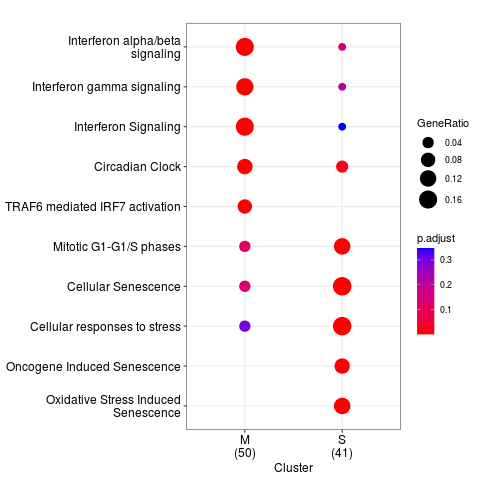

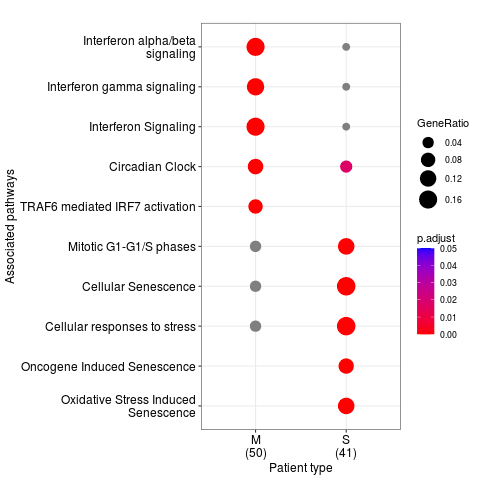

In [34]:
%%R
p <- dotplot(ck, showCategory=5) + 
    labs(y = 'Associated pathways', x = 'Patient type') + 
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red")
# ggsave(p, filename=sprintf('%s/dotplot_enrichr_tf_markers_%s.pdf', fig_home, cell_type), width=7, height=8)
p

## Cnetplot

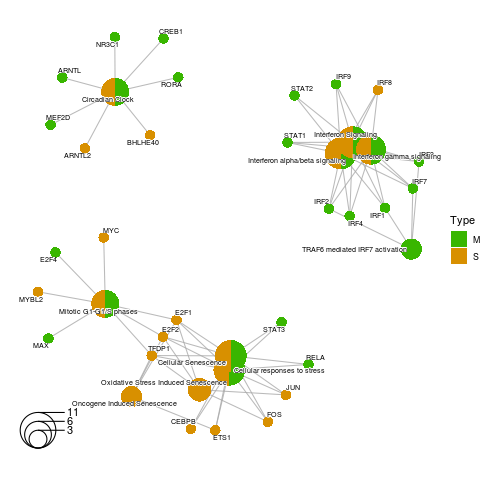

In [28]:
%%R
p <- cnetplot(ck, cex_category=1) + 
    scale_fill_manual(values=c(colors$green, colors$yellow, colors$red)) +
    guides(fill=guide_legend(title="Type"))
p <- remove_legend_title(p)
# ggsave(p, filename=sprintf('%s/cnetplot_enrichr_tf_markers_%s.pdf', fig_home, cell_type))
p

## Macrophages

The `EnrichR` results were produced with the following command:

```python
python run_enrichr.py -i /gpfs/projects/bsc08/shared_projects/scGRN_analysis/Data_home/res/covid_19/cell_types/Macrophage/data/Seurat/regulon/tf_markers_df_Macrophage.tsv -g gene -c cluster -q ''p_val_adj' < 0.05 & 'avg_log2FC' > 1'
```

### Loading the data

In [35]:
cell_type = 'Macrophage'
types = ['C', 'M', 'S']
db = 'Reactome'
is_positive_markers = True  # True if extract only positive markers

tf_markers_df = pd.read_csv(os.path.join(
    _DATA_HOME, 'cell_types', cell_type, 'data', 'Seurat', 
    'regulon', f'tf_markers_df_{cell_type}.tsv'
), sep='\t')

if is_positive_markers:
    tf_markers_df = tf_markers_df[
        (tf_markers_df['p_val_adj'] < 0.05) & (tf_markers_df['avg_log2FC'] > 1)
    ]
else:
    tf_markers_df = tf_markers_df[
        (tf_markers_df['p_val_adj'] < 0.05) & (tf_markers_df['avg_log2FC'] < -1)
    ]
genes = tf_markers_df[['cluster', 'gene']].groupby('cluster').agg(lambda x: list(x)).to_dict()['gene']

enrichr_res = pd.read_csv(os.path.join(
    _DATA_HOME, 'cell_types', cell_type, 'data', 'Seurat', 
    'regulon', f'enrichr_tf_markers_df_{cell_type}.tsv'
), sep='\t')

print('The TF markers based on differential analysis of VIPER scores:')
display(tf_markers_df)
print()
print('Corresponding enriched functional terms using EnrichR:')
display(enrichr_res)

The TF markers based on differential analysis of VIPER scores:


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
IRF4,8.750582e-70,1.288576,0.736,0.381,1.102573e-67,M,IRF4
NR1H2,2.275548e-04,1.040075,0.560,0.547,2.867190e-02,M,NR1H2
NFKB2.1,0.000000e+00,17.302542,0.135,0.001,0.000000e+00,S,NFKB2
NFKB1.1,0.000000e+00,14.800592,0.125,0.001,0.000000e+00,S,NFKB1
RELA.1,0.000000e+00,14.232002,0.199,0.002,0.000000e+00,S,RELA
...,...,...,...,...,...,...,...
RXRA.2,0.000000e+00,3.320984,0.596,0.234,0.000000e+00,C,RXRA
E2F1.2,0.000000e+00,2.897388,0.854,0.614,0.000000e+00,C,E2F1
REST.2,0.000000e+00,2.300194,0.719,0.228,0.000000e+00,C,REST
USF2.2,7.315586e-149,1.760253,0.094,0.090,9.217638e-147,C,USF2



Corresponding enriched functional terms using EnrichR:


,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,cluster
0,Nuclear Receptor transcription pathway Homo sa...,3/51,0.000007,0.000744,0,0,103.838542,1233.189351,ESRRA;RXRA;RARA,C
1,Activation of anterior HOX genes in hindbrain ...,3/89,0.000037,0.001330,0,0,57.845930,589.850033,YY1;RXRA;RARA,C
2,Activation of HOX genes during differentiation...,3/89,0.000037,0.001330,0,0,57.845930,589.850033,YY1;RXRA;RARA,C
3,Transcriptional activation of mitochondrial bi...,2/40,0.000403,0.009507,0,0,80.757085,631.279748,ESRRA;RXRA,C
4,Signaling by Retinoic Acid Homo sapiens R-HSA-...,2/42,0.000444,0.009507,0,0,76.711538,592.142891,RXRA;RARA,C
...,...,...,...,...,...,...,...,...,...,...
342,Axon guidance Homo sapiens R-HSA-422475,1/515,0.882762,0.897295,0,0,0.466061,0.058118,CREB1,S
343,Post-translational protein modification Homo s...,1/521,0.885692,0.897295,0,0,0.460541,0.055903,MITF,S
344,Metabolism of lipids and lipoproteins Homo sap...,1/659,0.936268,0.944409,0,0,0.361364,0.023797,SREBF1,S
345,Signaling by GPCR Homo sapiens R-HSA-372790,1/1293,0.995878,0.997439,0,0,0.177980,0.000735,CREB1,S


### Processing the data

We need to process the `EnrichR` output to use `clusterProfiler` for visualization.

In [36]:
processed_types = enrichr_res['cluster'].unique()
enrichr_res_processed = (
    enrichr_res.rename(columns={'Adjusted P-value': 'p.adjust', 'Combined Score': 'Score', 'cluster': 'type'})
        .assign(
            Genes=enrichr_res['Genes'].map(lambda x: x.replace(';', '/')),
            Ratio=enrichr_res.apply(
                lambda x: f"{x['Overlap'][:x['Overlap'].find('/')]}/{len(genes[x['cluster']])}", 
                axis=1
            )
        )        
)
if db == 'Reactome':
    enrichr_res_processed['Term'] = enrichr_res_processed['Term'].map(lambda x: x[:x.find('Homo')-1])
final_df = enrichr_res_processed.assign(ID=[f'ID_{el}' for el in pd.factorize(enrichr_res_processed['Term'])[0] + 1])

print('Processed')
final_df

Processed


,Term,Overlap,P-value,p.adjust,Old P-value,Old Adjusted P-value,Odds Ratio,Score,Genes,type,Ratio,ID
0,Nuclear Receptor transcription pathway,3/51,0.000007,0.000744,0,0,103.838542,1233.189351,ESRRA/RXRA/RARA,C,3/15,ID_1
1,Activation of anterior HOX genes in hindbrain ...,3/89,0.000037,0.001330,0,0,57.845930,589.850033,YY1/RXRA/RARA,C,3/15,ID_2
2,Activation of HOX genes during differentiation,3/89,0.000037,0.001330,0,0,57.845930,589.850033,YY1/RXRA/RARA,C,3/15,ID_3
3,Transcriptional activation of mitochondrial bi...,2/40,0.000403,0.009507,0,0,80.757085,631.279748,ESRRA/RXRA,C,2/15,ID_4
4,Signaling by Retinoic Acid,2/42,0.000444,0.009507,0,0,76.711538,592.142891,RXRA/RARA,C,2/15,ID_5
...,...,...,...,...,...,...,...,...,...,...,...,...
342,Axon guidance,1/515,0.882762,0.897295,0,0,0.466061,0.058118,CREB1,S,1/82,ID_281
343,Post-translational protein modification,1/521,0.885692,0.897295,0,0,0.460541,0.055903,MITF,S,1/82,ID_282
344,Metabolism of lipids and lipoproteins,1/659,0.936268,0.944409,0,0,0.361364,0.023797,SREBF1,S,1/82,ID_84
345,Signaling by GPCR,1/1293,0.995878,0.997439,0,0,0.177980,0.000735,CREB1,S,1/82,ID_283


### Moving to `R` using `rpy2`

In [37]:
%%R -i final_df,processed_types,fig_home,cell_type

processed_types = unlist(processed_types)

egos <- list()
for (group in processed_types){
    df <- final_df[final_df['type'] == group,]
    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')
}

merge_cmd = ""
for (t in processed_types){
    merge_cmd = paste0(merge_cmd, sprintf("%s=egos[['%s']], ", t, t))
}

merge_cmd = sprintf("merge_result(list(%s))", substr(merge_cmd, 1, nchar(merge_cmd) - 2))

ck <- eval(parse(text=merge_cmd))
ck@fun <- 'enrichGO'

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



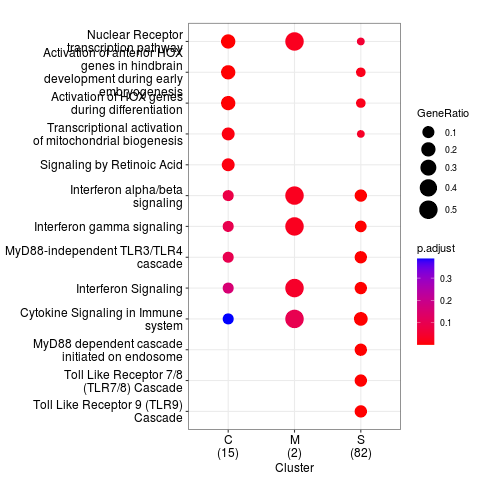

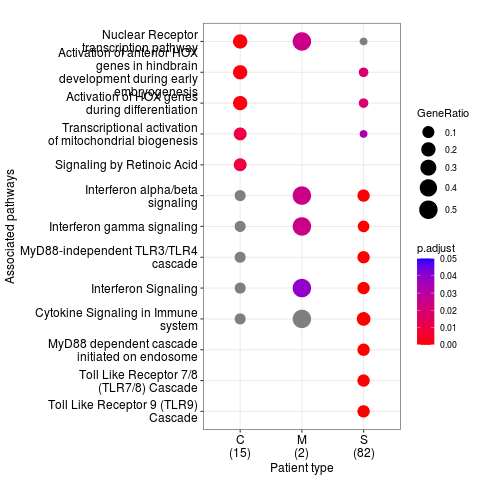

In [38]:
%%R
p <- dotplot(ck, showCategory=5) + 
    labs(y = 'Associated pathways', x = 'Patient type') + 
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red")
# ggsave(p, filename=sprintf('%s/dotplot_enrichr_tf_markers_%s.pdf', fig_home, cell_type), width=7, height=8)
p

## Cnetplot

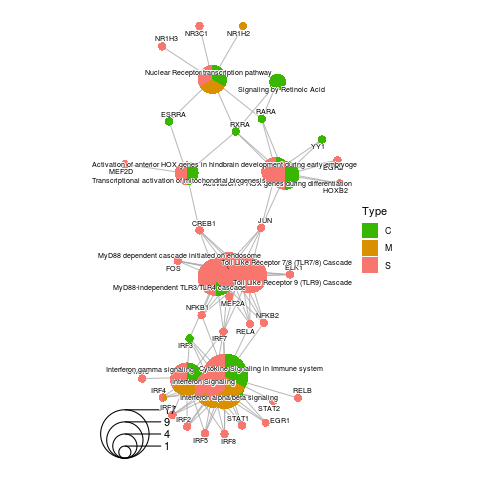

In [39]:
%%R
p <- cnetplot(ck, cex_category=1) + 
    scale_fill_manual(values=c(colors$green, colors$yellow, colors$red)) +
    guides(fill=guide_legend(title="Type"))
p <- remove_legend_title(p)
# ggsave(p, filename=sprintf('%s/cnetplot_enrichr_tf_markers_%s.pdf', fig_home, cell_type))
p

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



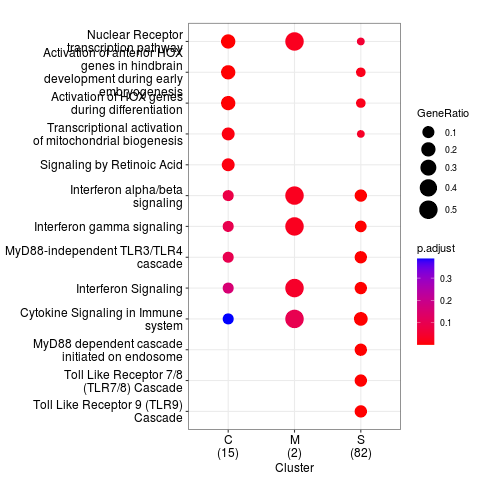

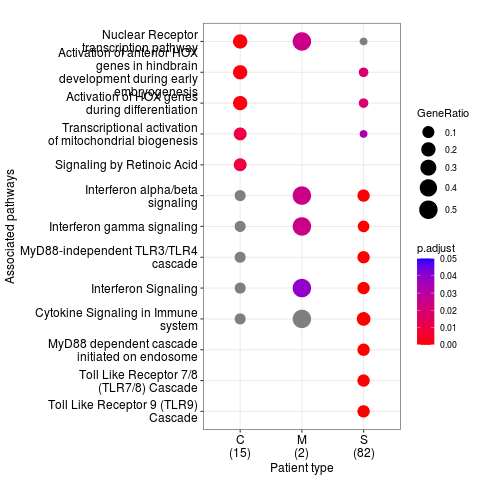

In [7]:
%%R
p <- dotplot(ck, showCategory=5) + 
    theme(axis.text.y = element_text(size = 12)) +
    labs(y = 'Associated pathways', x = 'Patient type') +
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red")
ggsave(p, filename='tmp/dotplot_enrichr.pdf', width=7, height=10)
p

## Cnetplot

R[write to console]: Saving 6.67 x 6.67 in image



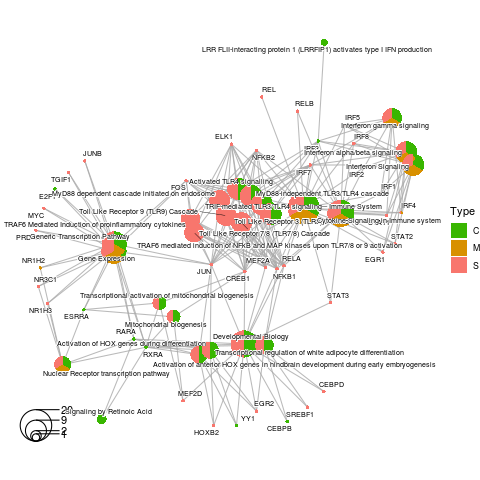

In [97]:
%%R
p <- cnetplot(ck, cex_category=1, 10) + 
    scale_fill_manual(values=c(colors$green, colors$yellow, colors$red)) +
    guides(fill=guide_legend(title="Type"))
p <- remove_legend_title(p)
ggsave(p, filename='tmp/cnetplot_enrichr.pdf')
p

## Macrophage - 2 groups

In [265]:
types = ['H', 'C']
genes = {
    'H': 'RFX5 MYC BHLHE40 ATF3 TFAP2C BCL6 ZEB2 GATA2 HNF4A ZBTB7A CREB1 FOXA2 FOXP1 ZNF24 FOXP2 MXI1 HBP1 SNAI2 ELF5 SREBF2 E2F4 HNF1A'.split(' '),
    'C': 'STAT2 IRF9 IRF1 STAT1 IRF2 FOXL2 IKZF1 KLF6 REL ELF1 RELA STAT3 ATF2 NFKB1 JUN HIF1A SMAD1 NFATC1 ZNF384 BATF STAT6 RUNX1 FOXO4 AHR RELB RBPJ KLF9 KLF1 JUNB ZNF217 NFE2L2 ARID3A PAX5 NFE2 MEF2A TBP ZNF740 SRF CEBPB SMAD4 IRF4 ELK1 EPAS1 CUX1 THAP1 ELK4 NEUROD1 KLF4 TCF7 KDM5B SP3 SMAD3 MAFF FOXO3 ETS2 ETV1 TP53 OTX2 ETS1 ELF3 ESR1 ZKSCAN1 PKNOX1 PROX1 FOSL2 ATF1 TFAP2A PRDM14 RXRA BCL11A SOX13 TP63 SP2 PBX2 E2F1 FLI1 PBX3 MEF2B FOSL1 ERG SOX6 CTCFL MYB WT1 VDR FOXM1 ZNF592 ARNTL TFAP4 YY1 LEF1 TWIST1 E2F3 FOXA1 SIX2 MAZ MAFB CREB3 SPIB ZBTB11 RARA PPARA TP73 PRDM1 GFI1B MAFG CLOCK USF1 MAX TAL1 NCOA2 LYL1 GABPA EBF1 TCF12 NCOA1 ATF4 MAF FOXK2 TCF3 NCOA3 E2F7 BACH1 FOXO1 CREB3L1 TEAD2 ZNF143 FOS GRHL2 USF2 NR4A1 TBX21 CEBPG IRF3 HSF1 TEAD4 ARID2 ATF6 SP4 POU2F2 ZFX CREM STAT5A SPI1 NR1H2'.split(' ')
}
dfs = {}
for t in types:
    dfs[t] = pd.read_csv(f'tmp/Macrophage_{t}_2_groups.txt', sep='\t')
dfs['C'].head()

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Adipogenesis,22/133,6.209815e-24,3.191845e-21,0,0,31.814839,1700.054923,MEF2A;STAT5A;NCOA1;NCOA2;CEBPB;MEF2B;SMAD3;EPA...
1,SMAD2/3 nuclear pathway,17/82,1.748703e-20,4.494167e-18,0,0,40.436298,1839.561529,NCOA1;ATF2;NCOA2;CEBPB;JUN;SMAD4;SMAD3;MAX;VDR...
2,AP-1 transcription factor network,15/70,1.965615e-18,3.367754e-16,0,0,41.538462,1693.553254,ATF2;JUN;NFATC1;FOS;ETS1;HIF1A;ESR1;FOSL2;FOSL...
3,Regular glucocorticoid receptor pathway,15/82,2.523312e-17,3.242455e-15,0,0,34.078071,1302.408485,NCOA1;STAT5A;NCOA2;JUN;SPI1;TBP;STAT1;NFATC1;F...
4,Pathways in cancer,23/325,1.710464e-16,1.758357e-14,0,0,12.206031,443.135026,STAT5A;JUN;SMAD4;SPI1;SMAD3;EPAS1;MAX;STAT1;TC...


In [266]:
processed_dfs = {}
top_n = 10

for t in types:
    processed_dfs[t] = dfs[t].sort_values('Adjusted P-value', ascending=True)  # .iloc[:top_n, :]
    processed_dfs[t]['type'] = t
    processed_dfs[t] = processed_dfs[t].rename(columns={'Adjusted P-value': 'p.adjust', 'Combined Score': 'Score'})
    processed_dfs[t]['Genes'] = processed_dfs[t]['Genes'].map(lambda x: x.replace(';', '/'))
    processed_dfs[t]['Ratio'] = processed_dfs[t].apply(lambda x: f"{x['Overlap'][:x['Overlap'].find('/')]}/{len(genes[t])}", axis=1)
    
final_df = pd.concat([df for df in processed_dfs.values()], axis=0)
final_df = final_df.assign(ID=[f'ID_{el}' for el in pd.factorize(final_df['Term'])[0] + 1])
final_df

,Term,Overlap,P-value,p.adjust,Old P-value,Old Adjusted P-value,Odds Ratio,Score,Genes,type,Ratio,ID
0,SMAD2/3 nuclear pathway,5/82,2.552167e-08,0.000006,0,0,76.016043,1329.044582,CREB1/MYC/HNF4A/E2F4/ATF3,H,5/22,ID_1
1,HNF3B pathway,4/45,1.587545e-07,0.000017,0,0,108.059621,1691.771371,CREB1/HNF4A/HNF1A/FOXA2,H,4/22,ID_2
2,HIF-1 transcriptional activity in hypoxia,4/66,7.564084e-07,0.000052,0,0,71.383513,1006.128081,CREB1/HNF4A/BHLHE40/GATA2,H,4/22,ID_3
3,AP-1 transcription factor network,4/70,9.595296e-07,0.000052,0,0,67.043771,929.013650,CREB1/MYC/GATA2/ATF3,H,4/22,ID_4
4,Gene expression regulation in pancreatic beta ...,3/20,1.300921e-06,0.000056,0,0,185.396285,2512.571623,HNF4A/HNF1A/FOXA2,H,3/22,ID_5
...,...,...,...,...,...,...,...,...,...,...,...,...
509,Integrin signaling pathway,1/155,6.776835e-01,0.682999,0,0,0.888393,0.345651,JUN,C,1/145,ID_536
510,HIV infection,1/200,7.683650e-01,0.772876,0,0,0.685930,0.180736,TBP,C,1/145,ID_537
511,Endocytosis,1/201,7.700613e-01,0.773069,0,0,0.682465,0.178318,SMAD3,C,1/145,ID_538
512,Axon guidance,1/325,9.078422e-01,0.909612,0,0,0.418617,0.040474,NFATC1,C,1/145,ID_212


In [267]:
%%R -i final_df

egos <- list()
for (group in c('H', 'C')){
    df <- final_df[final_df['type'] == group,]
    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')
}

ck <- merge_result(list(H=egos[['H']], C=egos[['C']]))
ck@fun <- 'enrichGO'

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



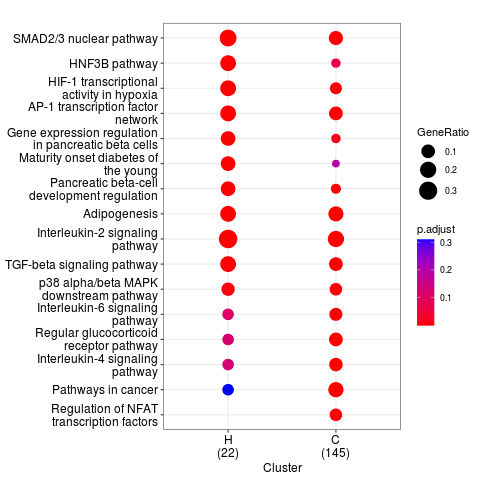

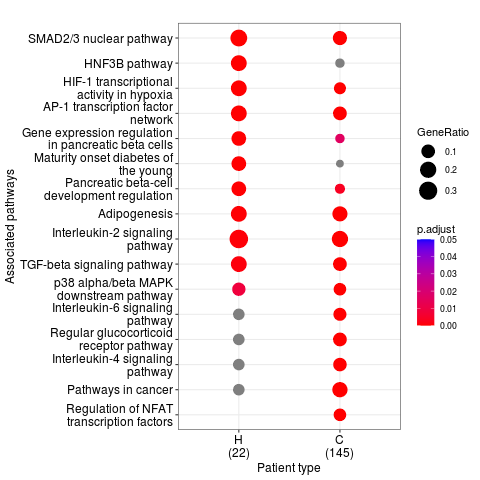

In [268]:
%%R -i top_n
p <- dotplot(ck, showCategory=10) + labs(y = 'Associated pathways', x = 'Patient type') + 
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red")
ggsave(p, filename='tmp/dotplot_enrichr.pdf', width=7, height=8)
p

## Cnetplot

R[write to console]: Saving 6.67 x 6.67 in image



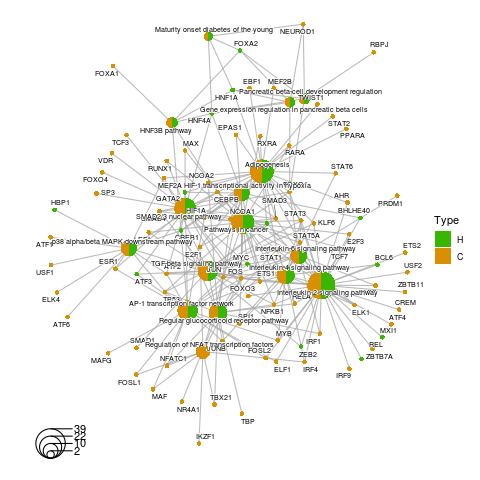

In [269]:
%%R
p <- cnetplot(ck, cex_category=1, showCategory=10) + 
    scale_fill_manual(values=c(colors$green, colors$yellow)) +
    guides(fill=guide_legend(title="Type"))
p <- remove_legend_title(p)
ggsave(p, filename='tmp/cnetplot_enrichr.pdf')
p

## NK cell

In [272]:
types = ['C', 'M', 'S']
genes = {
    'C': 'BCL6 ATF3 HBP1 BHLHE40 MXI1'.split(' '),
    'M': 'LYL1 GABPA NFYB MEF2C STAT2 IRF2 ELF5 POU4F2 IKZF1 ETV1 IRF9'.split(' '),
    'S': 'FOXL2 JUN REL RELA ATF2 ESR1 FOS NFKB1 CEBPB STAT3 FOXM1 HIF1A SPI1'.split(' ')
}
dfs = {}
for t in types:
    dfs[t] = pd.read_csv(f'tmp/NK_cell_1_{t}.txt', sep='\t')
dfs['C'].head()

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,p53 signaling pathway,2/139,0.000473,0.012422,0,0,96.632603,739.854589,BCL6;ATF3
1,Interleukin-2 signaling pathway,3/847,0.000710,0.012422,0,0,34.036137,246.777655,BCL6;BHLHE40;MXI1
2,BDNF signaling pathway,2/261,0.001653,0.019285,0,0,50.800515,325.384697,HBP1;ATF3
3,Hypertrophy pathway,1/20,0.004990,0.030944,0,0,262.842105,1393.123889,ATF3
4,C-Myc pathway,1/25,0.006235,0.030944,0,0,208.031250,1056.296661,HBP1


In [273]:
processed_dfs = {}
top_n = 5

for t in types:
    processed_dfs[t] = dfs[t].sort_values('Adjusted P-value', ascending=True) # .iloc[:top_n, :]
    processed_dfs[t]['type'] = t
    processed_dfs[t] = processed_dfs[t].rename(columns={'Adjusted P-value': 'p.adjust', 'Combined Score': 'Score'})
    processed_dfs[t]['Genes'] = processed_dfs[t]['Genes'].map(lambda x: x.replace(';', '/'))
    processed_dfs[t]['Ratio'] = processed_dfs[t].apply(lambda x: f"{x['Overlap'][:x['Overlap'].find('/')]}/{len(genes[t])}", axis=1)
    
final_df = pd.concat([df for df in processed_dfs.values()], axis=0).reset_index(drop=True)
final_df = final_df.assign(ID=[f'ID_{el}' for el in pd.factorize(final_df['Term'])[0] + 1])
final_df

,Term,Overlap,P-value,p.adjust,Old P-value,Old Adjusted P-value,Odds Ratio,Score,Genes,type,Ratio,ID
0,p53 signaling pathway,2/139,0.000473,0.012422,0,0,96.632603,739.854589,BCL6/ATF3,C,2/6,ID_1
1,Interleukin-2 signaling pathway,3/847,0.000710,0.012422,0,0,34.036137,246.777655,BCL6/BHLHE40/MXI1,C,3/6,ID_2
2,BDNF signaling pathway,2/261,0.001653,0.019285,0,0,50.800515,325.384697,HBP1/ATF3,C,2/6,ID_3
3,SMAD2/3 nuclear pathway,1/82,0.020334,0.030944,0,0,61.462963,239.425203,ATF3,C,1/6,ID_4
4,ATM-dependent DNA damage response,1/82,0.020334,0.030944,0,0,61.462963,239.425203,BCL6,C,1/6,ID_5
...,...,...,...,...,...,...,...,...,...,...,...,...
414,Focal adhesion,1/233,0.141342,0.143239,0,0,7.095905,13.883651,JUN,S,1/13,ID_340
415,FSH regulation of apoptosis,1/263,0.158135,0.159722,0,0,6.273855,11.570914,ESR1,S,1/13,ID_341
416,Generic transcription pathway,1/377,0.219221,0.220683,0,0,4.346410,6.596432,ESR1,S,1/13,ID_342
417,Disease,1/674,0.359680,0.360875,0,0,2.391530,2.445436,STAT3,S,1/13,ID_35


In [274]:
%%R -i final_df

egos <- list()
for (group in c('C', 'M', 'S')){
    df <- final_df[final_df['type'] == group,]
    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')
}

ck <- merge_result(list(C=egos[['C']], M=egos[['M']], S=egos[['S']]))
ck@fun <- 'enrichGO'

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



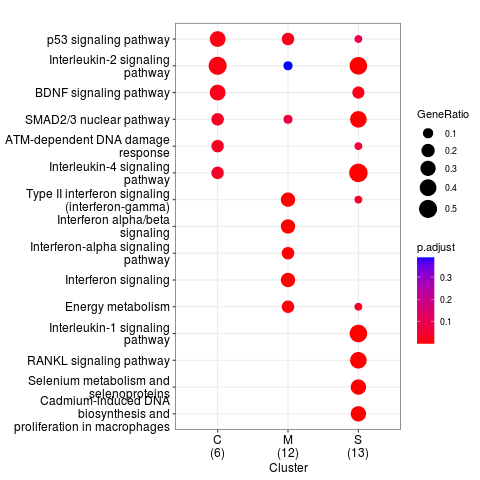

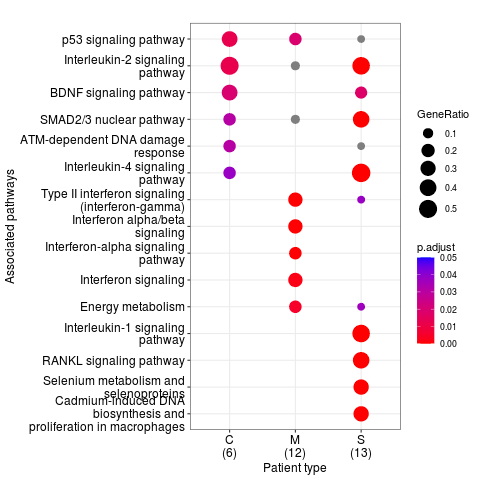

In [275]:
%%R
p <- dotplot(ck, showCategory=5) + 
    labs(y = 'Associated pathways', x = 'Patient type') + 
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red")
ggsave(p, filename='tmp/dotplot_enrichr.pdf', width=7, height=8)
p

## Cnetplot

R[write to console]: Saving 6.67 x 6.67 in image



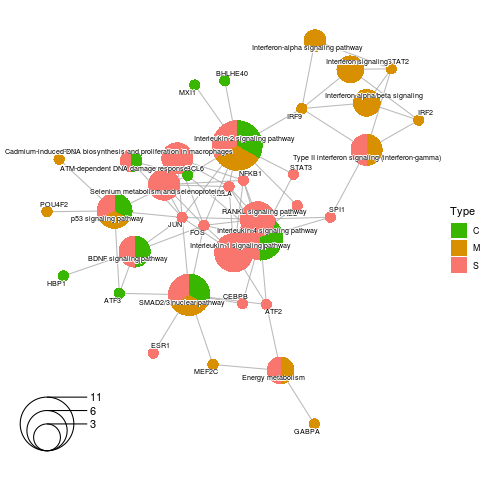

In [276]:
%%R
p <- cnetplot(ck, cex_category=1) + 
    scale_fill_manual(values=c(colors$green, colors$yellow, colors$red)) +
    guides(fill=guide_legend(title="Type"))
p <- remove_legend_title(p)
ggsave(p, filename='tmp/cnetplot_enrichr.pdf')
p

# PYSCENIC SCORES DE ANALYSIS

## T cells

In [116]:
data = 'T_cells'
types = ['C', 'M', 'S']
db = 'Reactome'
df = pd.concat([
    pd.read_csv(
        f'/gpfs/home/bsc08/bsc08890/tmp/cohort_ana/tmp_enrichr_{data}_all_target_{t}.tsv', 
        header=None, names=['gene']
    ).assign(cluster=t) for t in types
], axis=0)

genes = df[['cluster', 'gene']].groupby('cluster').agg(lambda x: list(x)).to_dict()['gene']
dfs = {}
for t in types:
    dfs[t] = pd.read_csv(f'tmp/cohort_ana/tmp_enrichr_{data}_all_target_{t}.tsv', sep='\t')
dfs['C'].head()

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Netrin-1 signaling Homo sapiens R-HSA-373752,1/42,0.016680,0.113778,0,0,69.515679,284.566398,SIAH1
1,Intra-Golgi traffic Homo sapiens R-HSA-6811438,1/44,0.017468,0.113778,0,0,66.275748,268.243567,GOLIM4
2,Amyloid fiber formation Homo sapiens R-HSA-977225,1/68,0.026883,0.113778,0,0,42.484009,153.633295,SIAH1
3,ISG15 antiviral mechanism Homo sapiens R-HSA-1...,1/72,0.028444,0.113778,0,0,40.082495,142.685748,EIF4E3
4,Antiviral mechanism by IFN-stimulated genes Ho...,1/72,0.028444,0.113778,0,0,40.082495,142.685748,EIF4E3


In [117]:
processed_dfs = {}
processed_types = []
top_n = 5

for t in types:
    processed_dfs[t] = dfs[t].sort_values('Adjusted P-value', ascending=True) # .iloc[:top_n, :]
    processed_dfs[t]['type'] = t
    processed_dfs[t] = processed_dfs[t].rename(columns={'Adjusted P-value': 'p.adjust', 'Combined Score': 'Score'})
    processed_dfs[t]['Genes'] = processed_dfs[t]['Genes'].map(lambda x: x.replace(';', '/'))
    processed_dfs[t]['Ratio'] = processed_dfs[t].apply(lambda x: f"{x['Overlap'][:x['Overlap'].find('/')]}/{len(genes[t])}", axis=1) if len(processed_dfs[t]) != 0 else None
    if len(processed_dfs[t]) != 0:
        processed_types.append(t)
    processed_dfs[t]['Term'] = processed_dfs[t]['Term'].map(lambda x: x[:x.find('Homo')-1])
    
final_df = pd.concat([df for df in processed_dfs.values()], axis=0).reset_index(drop=True)
final_df = final_df.assign(ID=[f'ID_{el}' for el in pd.factorize(final_df['Term'])[0] + 1])
final_df

,Term,Overlap,P-value,p.adjust,Old P-value,Old Adjusted P-value,Odds Ratio,Score,Genes,type,Ratio,ID
0,Netrin-1 signaling,1/42,0.016680,0.113778,0,0,69.515679,284.566398,SIAH1,C,1/21,ID_1
1,Intra-Golgi traffic,1/44,0.017468,0.113778,0,0,66.275748,268.243567,GOLIM4,C,1/21,ID_2
2,Amyloid fiber formation,1/68,0.026883,0.113778,0,0,42.484009,153.633295,SIAH1,C,1/21,ID_3
3,ISG15 antiviral mechanism,1/72,0.028444,0.113778,0,0,40.082495,142.685748,EIF4E3,C,1/21,ID_4
4,Antiviral mechanism by IFN-stimulated genes,1/72,0.028444,0.113778,0,0,40.082495,142.685748,EIF4E3,C,1/21,ID_5
...,...,...,...,...,...,...,...,...,...,...,...,...
232,Cytokine Signaling in Immune system,1/620,0.530561,0.550582,0,0,1.359626,0.861760,NUP62,S,1/111,ID_16
233,Disease,1/725,0.587978,0.604463,0,0,1.156137,0.613985,NUP62,S,1/111,ID_81
234,Gene Expression,2/1631,0.593695,0.604690,0,0,1.023885,0.533843,ZNF254/NUP62,S,2/111,ID_51
235,Generic Transcription Pathway,1/812,0.630393,0.636176,0,0,1.027449,0.474077,ZNF254,S,1/111,ID_116


In [118]:
%%R -i final_df,processed_types

processed_types = unlist(processed_types)

egos <- list()
for (group in processed_types){
    df <- final_df[final_df['type'] == group,]
    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')
}

merge_cmd = ""
for (t in processed_types){
    merge_cmd = paste0(merge_cmd, sprintf("%s=egos[['%s']], ", t, t))
}

merge_cmd = sprintf("merge_result(list(%s))", substr(merge_cmd, 1, nchar(merge_cmd) - 2))

ck <- eval(parse(text=merge_cmd))
ck@fun <- 'enrichGO'

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



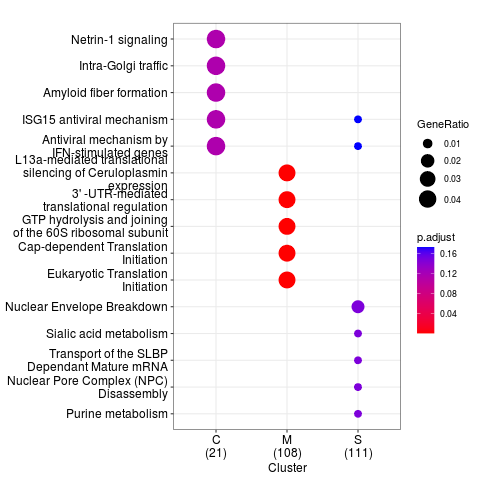

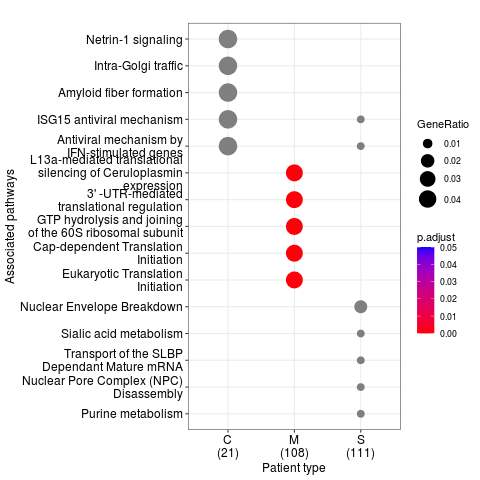

In [119]:
%%R
p <- dotplot(ck, showCategory=5) + 
    labs(y = 'Associated pathways', x = 'Patient type') + 
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red")
ggsave(p, filename='tmp/dotplot_enrichr.pdf', width=7, height=8)
p

## Cnetplot

In [ ]:
%%R
p <- cnetplot(ck, cex_category=1) + 
    scale_fill_manual(values=c(colors$green, colors$yellow, colors$red)) +
    guides(fill=guide_legend(title="Type"))
p <- remove_legend_title(p)
ggsave(p, filename='tmp/cnetplot_enrichr.pdf')
p

## T cells - fixed TFs

In [122]:
data = 'T_cells'
types = ['C', 'M', 'S']
TF = 'RFX2'
db = 'Reactome'
df = pd.concat([
    pd.read_csv(
        f'/gpfs/home/bsc08/bsc08890/tmp/cohort_ana/tmp_enrichr_{data}_{t}_{TF}_target_list.tsv', 
        header=None, names=['gene']
    ).assign(cluster=t) for t in types
], axis=0)

genes = df[['cluster', 'gene']].groupby('cluster').agg(lambda x: list(x)).to_dict()['gene']
dfs = {}
for t in types:
    dfs[t] = pd.read_csv(f'tmp/cohort_ana/tmp_enrichr_{data}_all_{TF}_target_{t}.tsv', sep='\t')
dfs['C'].head()

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Pperoxisome,1/104,0.030801,0.058527,0,0,38.623301,134.417360,SIAH1
1,Interferon Gamma Response,1/200,0.058527,0.058527,0,0,19.894472,56.465918,EIF4E3
2,E2F Targets,1/200,0.058527,0.058527,0,0,19.894472,56.465918,CSE1L


In [123]:
processed_dfs = {}
processed_types = []
top_n = 5

for t in types:
    processed_dfs[t] = dfs[t].sort_values('Adjusted P-value', ascending=True) # .iloc[:top_n, :]
    processed_dfs[t]['type'] = t
    processed_dfs[t] = processed_dfs[t].rename(columns={'Adjusted P-value': 'p.adjust', 'Combined Score': 'Score'})
    processed_dfs[t]['Genes'] = processed_dfs[t]['Genes'].map(lambda x: x.replace(';', '/'))
    processed_dfs[t]['Ratio'] = processed_dfs[t].apply(lambda x: f"{x['Overlap'][:x['Overlap'].find('/')]}/{len(genes[t])}", axis=1) if len(processed_dfs[t]) != 0 else None
    if len(processed_dfs[t]) != 0:
        processed_types.append(t)
    processed_dfs[t]['Term'] = processed_dfs[t]['Term'].map(lambda x: x[:x.find('Homo')-1])
    
final_df = pd.concat([df for df in processed_dfs.values()], axis=0).reset_index(drop=True)
final_df = final_df.assign(ID=[f'ID_{el}' for el in pd.factorize(final_df['Term'])[0] + 1])
final_df

,Term,Overlap,P-value,p.adjust,Old P-value,Old Adjusted P-value,Odds Ratio,Score,Genes,type,Ratio,ID
0,Pperoxiso,1/104,0.030801,0.058527,0,0,38.623301,134.417360,SIAH1,C,1/6,ID_1
1,Interferon Gamma Respon,1/200,0.058527,0.058527,0,0,19.894472,56.465918,EIF4E3,C,1/6,ID_2
2,E2F Targe,1/200,0.058527,0.058527,0,0,19.894472,56.465918,CSE1L,C,1/6,ID_3
3,IL-6/JAK/STAT3 Signali,1/87,0.008681,0.019900,0,0,231.534884,1099.002443,STAM2,M,1/2,ID_4
4,Spermatogenes,1/135,0.013455,0.019900,0,0,148.238806,638.676575,STAM2,M,1/2,ID_5
5,Myogenes,1/200,0.019900,0.019900,0,0,99.492462,389.713783,NAV2,M,1/2,ID_6
6,Estrogen Response Ear,1/200,0.019900,0.019900,0,0,99.492462,389.713783,NAV2,M,1/2,ID_7
7,Protein Secreti,1/96,0.037767,0.061865,0,0,29.920301,98.028208,ARFIP1,S,1/8,ID_8
8,PI3K/AKT/mTOR Signali,1/105,0.041243,0.061865,0,0,27.318681,87.099326,ACTR2,S,1/8,ID_9
9,mTORC1 Signali,1/200,0.077268,0.077268,0,0,14.208902,36.381530,ACTR2,S,1/8,ID_10


In [124]:
%%R -i final_df,processed_types

processed_types = unlist(processed_types)

egos <- list()
for (group in processed_types){
    df <- final_df[final_df['type'] == group,]
    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')
}

merge_cmd = ""
for (t in processed_types){
    merge_cmd = paste0(merge_cmd, sprintf("%s=egos[['%s']], ", t, t))
}

merge_cmd = sprintf("merge_result(list(%s))", substr(merge_cmd, 1, nchar(merge_cmd) - 2))

ck <- eval(parse(text=merge_cmd))
ck@fun <- 'enrichGO'

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



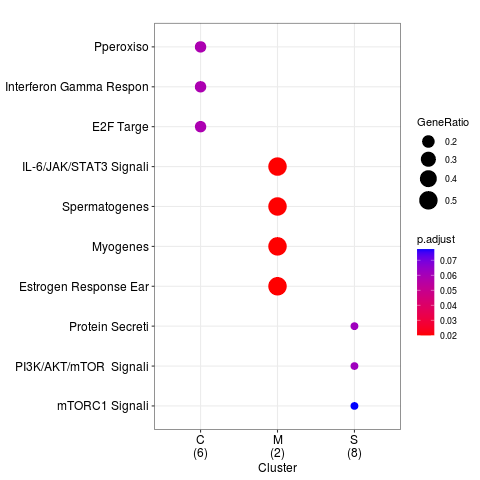

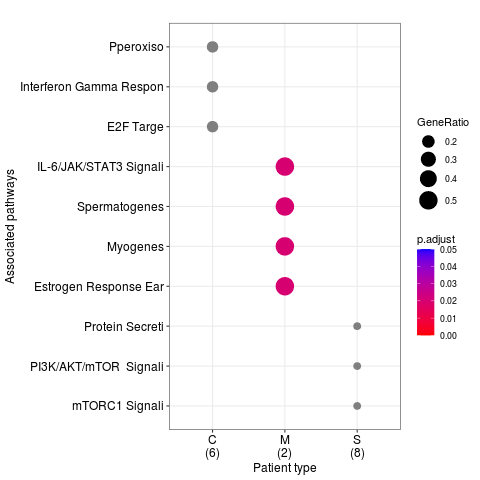

In [125]:
%%R
p <- dotplot(ck, showCategory=5) + 
    labs(y = 'Associated pathways', x = 'Patient type') + 
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red")
ggsave(p, filename='tmp/dotplot_enrichr.pdf', width=7, height=8)
p

## Cnetplot

In [ ]:
%%R
p <- cnetplot(ck, cex_category=1) + 
    scale_fill_manual(values=c(colors$green, colors$yellow, colors$red)) +
    guides(fill=guide_legend(title="Type"))
p <- remove_legend_title(p)
ggsave(p, filename='tmp/cnetplot_enrichr.pdf')
p

## Macrophage

In [4]:
types = ['C', 'M', 'S']
genes = {
    'C': 'SDC2 PHLDA2 UPP1 LDLRAD4 PER1 B3GNT5'.split(' '),
    'M': 'TMEM87A KLF4 RGS1 MYADM CD109 NFKBID METRNL CCL3 TAGAP MXD1 CBWD2 TUBB4B KLF2 EMP1 RALA XIAP ISG20 HSPA1A NR4A1 ABCD1 HSPA1B MIDN ZFP36 JUND SIRPA NECTIN2 PABPC4 P2RX4 LSS IER5 EMP3 CTSZ JOSD1 FAM102B LILRB4 FOSB RNF145 RHOB HESX1 PLK3 ANKH FNIP2 SLC6A6 NEAT1 MAPK6 ACTR2 GK TIMP2 CXCR4 PLXNB2 SBNO2 RHBDF2 PLTP CBX4 PRNP AHCYL1'.split(' '),
    'S': 'LITAF CYP1B1 ARL8B GARS LINC01010 SPSB1 HIVEP2 JUNB NFKB1 CTSC REL PNRC1 TXNIP USP15 CCL3L1 MIR155HG ATP1B3 IFIT2 TNFAIP3 CSF1 MAP1LC3B SH3BP5 PDE4DIP CMC2 TPT1 DUSP2 CSRNP1 ASAP1 ZFAS1 AK4 SLCO4A1 PLEK MRPS6 EIF1 TNFAIP3 NFKBIA KLF10 DUSP2 MIDN IL1R2 KDM6B ATXN7L3 CREB5'.split(' ')
}
dfs = {}
for t in types:
    dfs[t] = pd.read_csv(f'tmp/pyscenic_Macrophage_{t}.txt', sep='\t')
dfs['C'].head()

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,BDNF signaling pathway,2/261,0.002458,0.031456,0,0,38.098456,228.907807,UPP1;PHLDA2
1,FSH regulation of apoptosis,2/263,0.002495,0.031456,0,0,37.802682,226.562588,SDC2;UPP1
2,Pyrimidine salvage reactions,1/9,0.002697,0.031456,0,0,499.650000,2955.689739,UPP1
3,Pyrimidine catabolism,1/12,0.003595,0.031456,0,0,363.327273,2044.882815,UPP1
4,Heparan sulfate/heparin glycosaminoglycan (HS-...,1/20,0.005986,0.032819,0,0,210.263158,1076.207481,SDC2


In [5]:
processed_dfs = {}
top_n = 5

for t in types:
    processed_dfs[t] = dfs[t].sort_values('Adjusted P-value', ascending=True) # .iloc[:top_n, :]
    processed_dfs[t]['type'] = t
    processed_dfs[t] = processed_dfs[t].rename(columns={'Adjusted P-value': 'p.adjust', 'Combined Score': 'Score'})
    processed_dfs[t]['Genes'] = processed_dfs[t]['Genes'].map(lambda x: x.replace(';', '/'))
    processed_dfs[t]['Ratio'] = processed_dfs[t].apply(lambda x: f"{x['Overlap'][:x['Overlap'].find('/')]}/{len(genes[t])}", axis=1)
    
final_df = pd.concat([df for df in processed_dfs.values()], axis=0).reset_index(drop=True)
final_df = final_df.assign(ID=[f'ID_{el}' for el in pd.factorize(final_df['Term'])[0] + 1])
final_df

,Term,Overlap,P-value,p.adjust,Old P-value,Old Adjusted P-value,Odds Ratio,Score,Genes,type,Ratio,ID
0,BDNF signaling pathway,2/261,0.002458,0.031456,0,0,38.098456,228.907807,UPP1/PHLDA2,C,2/6,ID_1
1,FSH regulation of apoptosis,2/263,0.002495,0.031456,0,0,37.802682,226.562588,SDC2/UPP1,C,2/6,ID_2
2,Pyrimidine salvage reactions,1/9,0.002697,0.031456,0,0,499.650000,2955.689739,UPP1,C,1/6,ID_3
3,Pyrimidine catabolism,1/12,0.003595,0.031456,0,0,363.327273,2044.882815,UPP1,C,1/6,ID_4
4,O-linked glycosylation of mucins,1/63,0.018754,0.032819,0,0,64.296774,255.666481,B3GNT5,C,1/6,ID_5
...,...,...,...,...,...,...,...,...,...,...,...,...
505,GPCR ligand binding,1/410,0.572624,0.582715,0,0,1.194988,0.666236,CCL3L1,S,1/43,ID_242
506,Developmental biology,1/420,0.581487,0.589138,0,0,1.165871,0.632096,NFKB1,S,1/43,ID_155
507,Gene expression,2/968,0.596684,0.601895,0,0,1.008282,0.520644,GARS/JUNB,S,2/43,ID_263
508,Metabolism,2/1615,0.854499,0.858215,0,0,0.583274,0.091714,CYP1B1/AK4,S,2/43,ID_33


In [6]:
%%R -i final_df

egos <- list()
for (group in c('C', 'M', 'S')){
    df <- final_df[final_df['type'] == group,]
    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')
}

ck <- merge_result(list(C=egos[['C']], M=egos[['M']], S=egos[['S']]))
ck@fun <- 'enrichGO'

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



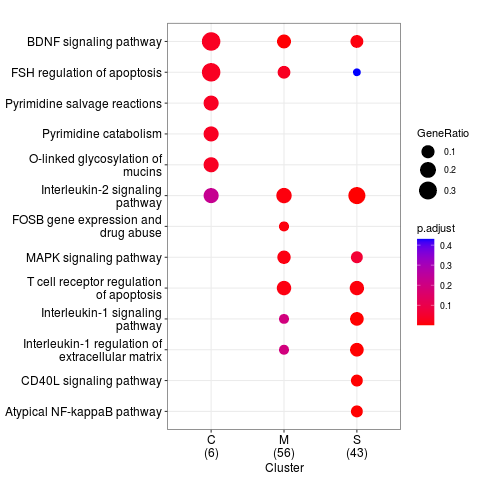

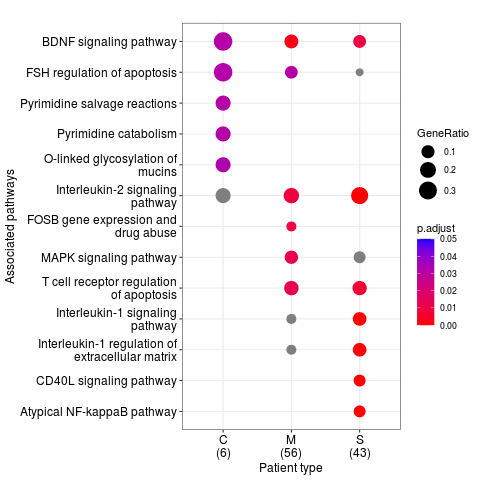

In [7]:
%%R
p <- dotplot(ck, showCategory=5) + 
    labs(y = 'Associated pathways', x = 'Patient type') + 
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red")
ggsave(p, filename='tmp/dotplot_enrichr.pdf', width=7, height=8)
p

## Cnetplot

R[write to console]: Saving 6.67 x 6.67 in image



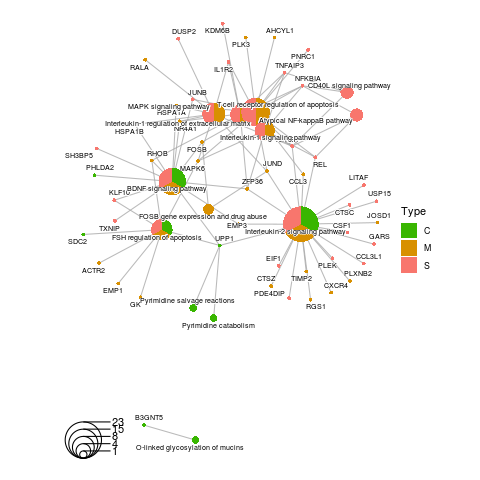

In [8]:
%%R
p <- cnetplot(ck, cex_category=1) + 
    scale_fill_manual(values=c(colors$green, colors$yellow, colors$red)) +
    guides(fill=guide_legend(title="Type"))
p <- remove_legend_title(p)
ggsave(p, filename='tmp/cnetplot_enrichr.pdf')
p

## NK cell

In [4]:
types = ['C', 'M', 'S']
genes = {
    'C': 'CAPZA1 TTC39C-AS1 GABARAPL2 NCOR1 BRD4 RPS6KA3 STAG2'.split(' '),
    'M': 'DNAJA1 SMIM15 LUCAT1 PSMA3 LCOR RABGAP1L LAGE3 COTL1 ZC3H18 LPIN2 NFE2L3 GCH1 KLF6 SKAP1 HSP90AA1 ADAR BTG1 COX17 SLC7A5 MYBL2 TAF8 RECQL4 CDCA5 MT1E CDC6 CDC20 CAB39 CERKL PKMYT1 JADE2 CLSPN ZBTB32 COX6A1 LBR LDB1 ANXA2 B9D2 SACS BBX RPLP0 CD151 MARK4 SQSTM1 HDAC2 ENOPH1 PRKAB2 DNAJC5 LAMP2 RABAC1 DYNLL1 ZNF750 MTRNR2L6 LSP1'.split(' '),
    'S': 'GUK1 RCC2 RPL18 MYL12A FAU PNISR SFXN1 RPS16 ERGIC3 SNRNP70 ALDOA RPL36 EIF4A2 RPL10 EIF6 RPLP2 SLC25A3 EZR RALY SRSF5 ACTN4 RPL28 TRAPPC1 PPP1CA RPL31 MZT2B IRF1 ATP1B3 PCBP1 EMD RPL38 FBXO7 PFDN5 CORO1A SNF8 UHMK1 RPS9 PRDX5 NACA CNBP GPX4 C9orf16 TRMT112 FYTTD1 BCAP31 SPTLC2 RPL5 PPP1R12A HOPX NDUFB6 SSR4 RPL10A RAC2 VDAC1 ANXA6 SON ZER1 RPS5 RPL9 LSP1 SNRPD2 RHOG RPL15 IRF4 C8orf59 XRCC5 SEC11A MMP25-AS1 MASTL UBA52 GABARAP RPL14 NFKB1 MYL6 HCST CD7 IL4I1 FFAR2 CCL2 GABARAP BZW1 TIMP2 TMEM140 NECAP1 ZNF800 SAMD4A CCL8 GSTO1 SKAP2 GLG1 SUPT3H DNPEP YWHAZ PPP3CC'.split(' ')
}
dfs = {}
for t in types:
    dfs[t] = pd.read_csv(f'tmp/pyscenic_NK_cells_{t}.txt', sep='\t')
dfs['C'].head()

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,RSK activation,1/6,0.002098,0.057103,0,0,666.266667,4108.590826,RPS6KA3
1,CREB phosphorylation,1/7,0.002448,0.057103,0,0,555.194444,3338.153583,RPS6KA3
2,Mitotic metaphase/anaphase transition,1/8,0.002797,0.057103,0,0,475.857143,2797.660500,STAG2
3,Advanced glycosylation endproduct receptor sig...,1/13,0.004542,0.057103,0,0,277.513889,1497.032601,CAPZA1
4,Innate immune system,2/319,0.005051,0.057103,0,0,24.827760,131.293049,RPS6KA3;CAPZA1


In [5]:
processed_dfs = {}
top_n = 5

for t in types:
    processed_dfs[t] = dfs[t].sort_values('Adjusted P-value', ascending=True) # .iloc[:top_n, :]
    processed_dfs[t]['type'] = t
    processed_dfs[t] = processed_dfs[t].rename(columns={'Adjusted P-value': 'p.adjust', 'Combined Score': 'Score'})
    processed_dfs[t]['Genes'] = processed_dfs[t]['Genes'].map(lambda x: x.replace(';', '/'))
    processed_dfs[t]['Ratio'] = processed_dfs[t].apply(lambda x: f"{x['Overlap'][:x['Overlap'].find('/')]}/{len(genes[t])}", axis=1)
    
final_df = pd.concat([df for df in processed_dfs.values()], axis=0).reset_index(drop=True)
final_df = final_df.assign(ID=[f'ID_{el}' for el in pd.factorize(final_df['Term'])[0] + 1])
final_df

,Term,Overlap,P-value,p.adjust,Old P-value,Old Adjusted P-value,Odds Ratio,Score,Genes,type,Ratio,ID
0,RSK activation,1/6,0.002098,0.057103,0,0,666.266667,4108.590826,RPS6KA3,C,1/7,ID_1
1,HES/HEY pathway,1/48,0.016682,0.057103,0,0,70.730496,289.530534,NCOR1,C,1/7,ID_2
2,Regulation of transcription by NOTCH1 intracel...,1/47,0.016337,0.057103,0,0,72.271739,297.350246,NCOR1,C,1/7,ID_3
3,Mitotic prometaphase,1/43,0.014955,0.057103,0,0,79.170635,332.729205,STAG2,C,1/7,ID_4
4,Transcriptional activity of SMAD2/SMAD3-SMAD4 ...,1/41,0.014264,0.057103,0,0,83.137500,353.335453,NCOR1,C,1/7,ID_5
...,...,...,...,...,...,...,...,...,...,...,...,...
765,FSH regulation of apoptosis,1/263,0.708850,0.715179,0,0,0.815010,0.280454,EZR,S,1/94,ID_75
766,Metabolism,6/1615,0.771740,0.776896,0,0,0.784295,0.203217,IL4I1/SPTLC2/NDUFB6/GUK1/GSTO1/ALDOA,S,6/94,ID_89
767,Generic transcription pathway,1/377,0.830330,0.834020,0,0,0.564610,0.104979,UBA52,S,1/94,ID_80
768,Signal transduction,3/1020,0.859532,0.861437,0,0,0.619141,0.093718,CCL2/FFAR2/NFKB1,S,3/94,ID_88


In [6]:
%%R -i final_df

egos <- list()
for (group in c('C', 'M', 'S')){
    df <- final_df[final_df['type'] == group,]
    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')
}

ck <- merge_result(list(C=egos[['C']], M=egos[['M']], S=egos[['S']]))
ck@fun <- 'enrichGO'

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



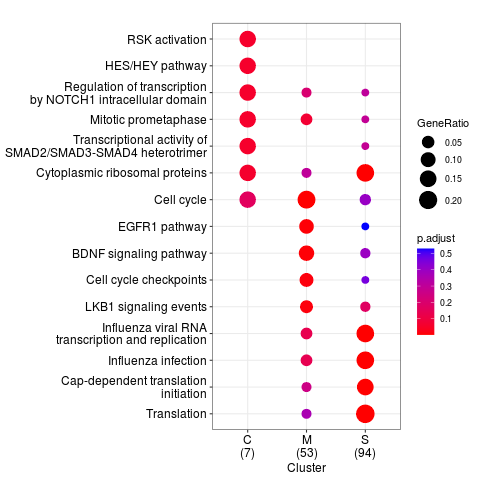

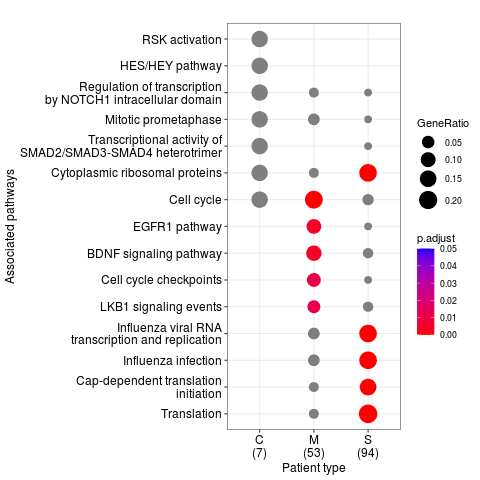

In [7]:
%%R
p <- dotplot(ck, showCategory=5) + 
    labs(y = 'Associated pathways', x = 'Patient type') + 
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red")
ggsave(p, filename='tmp/dotplot_enrichr.pdf', width=7, height=8)
p

## Cnetplot

R[write to console]: Saving 6.67 x 6.67 in image



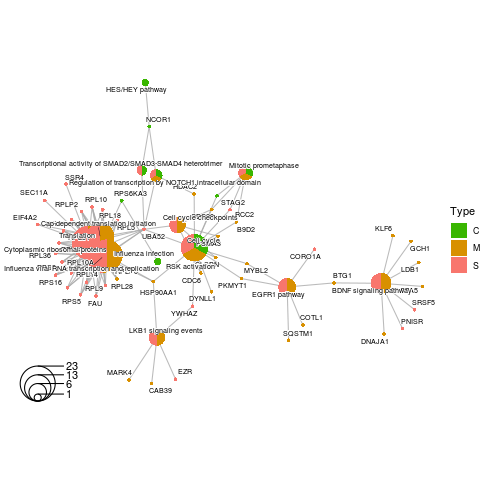

In [8]:
%%R
p <- cnetplot(ck, cex_category=1) + 
    scale_fill_manual(values=c(colors$green, colors$yellow, colors$red)) +
    guides(fill=guide_legend(title="Type"))
p <- remove_legend_title(p)
ggsave(p, filename='tmp/cnetplot_enrichr.pdf')
p

# COMMUNITY ANALYSIS

## T cells

In [136]:
_DATA_HOME = '/gpfs/projects/bsc08/bsc08890/res/covid_19'
algo = 'leiden'
data = 'T_cells'
data_type = 'all'
run_top_n = 50
db = 'Reactome'

community_data = pd.read_pickle(os.path.join(
    _DATA_HOME, 'cell_types', data, 'data', 'grnboost2', f'{algo}_communities', 
    f'raw_data_communities_info.pickle'
))

df = pd.concat([
        pd.DataFrame({
            'cluster': f'cluster_{i}',
            'gene': [el[: el.find(' ')] for el in vals.split('; ')][:run_top_n]
        }) for i, vals in community_data['all_sorted_genes'].iteritems()
], axis=0).reset_index(drop=True)
types = list(df['cluster'].unique())
num_nodes_per_cluster = community_data['num_nodes'].rename(lambda x: f'cluster_{x}')

genes = {
    cl: df[df['cluster'] == cl]['gene'].to_list() for cl in df['cluster'].unique()
}
dfs = {}
for t in types:
    dfs[t] = pd.read_csv(f'tmp/community_ana/tmp_enrichr_{data}_{data_type}_{t}.tsv', sep='\t')
dfs['cluster_0'].head()

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Immune System Homo sapiens R-HSA-168256,16/1547,5.971219e-07,0.000133,0,0,5.661505,81.135852,JUN;DUSP2;KLRB1;DUSP1;FOS;RASGRP2;TNF;NFKBIA;S...
1,Cytokine Signaling in Immune system Homo sapie...,8/620,1.386370e-04,0.012570,0,0,6.018674,53.467806,SOCS2;DUSP2;DUSP1;LTA;IL17F;IL7R;TNF;IL17A
2,Interleukin-17 signaling Homo sapiens R-HSA-44...,2/8,1.698630e-04,0.012570,0,0,138.500000,1202.251780,IL17F;IL17A
3,Activation of the AP-1 family of transcription...,2/10,2.721231e-04,0.015103,0,0,103.864583,852.650959,JUN;FOS
4,Fc epsilon receptor (FCERI) signaling Homo sap...,6/395,4.357214e-04,0.018447,0,0,6.857093,53.063664,NFKBIA;JUN;DUSP2;DUSP1;FOS;RASGRP2


In [137]:
processed_dfs = {}
processed_types = []
top_n = 5

for t in types:
    if len(dfs[t]) != 0:
        processed_types.append(t)
        processed_dfs[t] = dfs[t].sort_values('Adjusted P-value', ascending=True) # .iloc[:top_n, :]
        processed_dfs[t]['type'] = t
        processed_dfs[t] = processed_dfs[t].rename(columns={'Adjusted P-value': 'p.adjust', 'Combined Score': 'Score'})
        processed_dfs[t]['Genes'] = processed_dfs[t]['Genes'].map(lambda x: x.replace(';', '/'))
        processed_dfs[t]['Ratio'] = processed_dfs[t].apply(lambda x: f"{x['Overlap'][:x['Overlap'].find('/')]}/{len(genes[t])}", axis=1)
        if db == 'Reactome':
            processed_dfs[t]['Term'] = processed_dfs[t]['Term'].map(lambda x: x[:x.find('Homo')-1])
    
final_df = pd.concat([df for df in processed_dfs.values()], axis=0).reset_index(drop=True)
final_df = final_df.assign(ID=[f'ID_{el}' for el in pd.factorize(final_df['Term'])[0] + 1])
final_df

,Term,Overlap,P-value,p.adjust,Old P-value,Old Adjusted P-value,Odds Ratio,Score,Genes,type,Ratio,ID
0,Immune System,16/1547,5.971219e-07,0.000133,0,0,5.661505,81.135852,JUN/DUSP2/KLRB1/DUSP1/FOS/RASGRP2/TNF/NFKBIA/S...,cluster_0,16/50,ID_1
1,Cytokine Signaling in Immune system,8/620,1.386370e-04,0.012570,0,0,6.018674,53.467806,SOCS2/DUSP2/DUSP1/LTA/IL17F/IL7R/TNF/IL17A,cluster_0,8/50,ID_2
2,Interleukin-17 signaling,2/8,1.698630e-04,0.012570,0,0,138.500000,1202.251780,IL17F/IL17A,cluster_0,2/50,ID_3
3,Activation of the AP-1 family of transcription...,2/10,2.721231e-04,0.015103,0,0,103.864583,852.650959,JUN/FOS,cluster_0,2/50,ID_4
4,Toll Like Receptor 2 (TLR2) Cascade,3/92,1.578840e-03,0.018447,0,0,14.244083,91.889506,NFKBIA/JUN/FOS,cluster_0,3/50,ID_5
...,...,...,...,...,...,...,...,...,...,...,...,...
2172,Gene Expression,3/1631,7.857353e-01,0.808621,0,0,0.718360,0.173222,GTF3C2/MYBBP1A/ELL2,cluster_11,3/50,ID_64
2173,Transmembrane transport of small molecules,1/594,7.789512e-01,0.808621,0,0,0.666173,0.166415,SLC2A5,cluster_11,1/50,ID_210
2174,Metabolism of lipids and lipoproteins,1/659,8.131293e-01,0.828766,0,0,0.598350,0.123778,AGPAT5,cluster_11,1/50,ID_86
2175,Developmental Biology,1/786,8.656296e-01,0.873874,0,0,0.498245,0.071896,COL4A4,cluster_11,1/50,ID_103


In [138]:
%%R -i final_df,processed_types,num_nodes_per_cluster

# Define some useful functions
get_cl_from_tick <- function (x) substr(x, 1, as.integer(gregexpr('\n', x)) - 1)
cl_name_to_int <- function (x) substr(x, as.integer(gregexpr('_', x)) + 1, nchar(x))

processed_types = unlist(processed_types)

egos <- list()
for (group in processed_types){
    df <- final_df[final_df['type'] == group,]
    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')
}

merge_cmd = ""
for (t in processed_types){
    merge_cmd = paste0(merge_cmd, sprintf("%s=egos[['%s']], ", t, t))
}

merge_cmd = sprintf("merge_result(list(%s))", substr(merge_cmd, 1, nchar(merge_cmd) - 2))

ck <- eval(parse(text=merge_cmd))
ck@fun <- 'enrichGO'

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



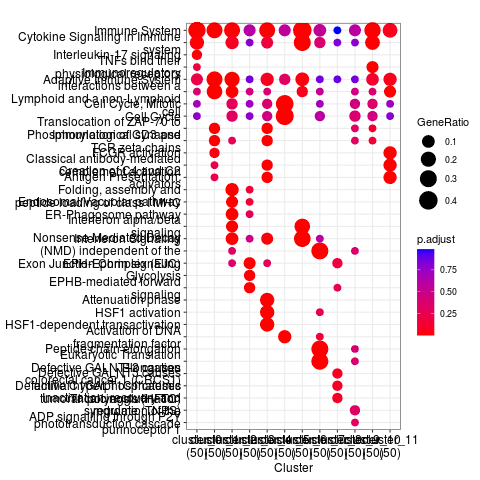

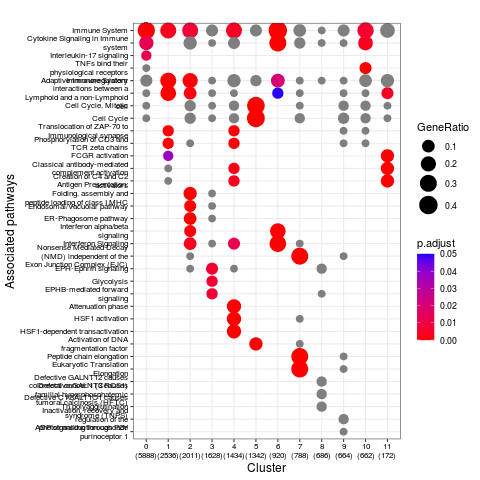

In [140]:
%%R
p <- dotplot(ck, showCategory=3) + 
    labs(y = 'Associated pathways', x = 'Cluster') + 
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red") +
    theme(axis.text.y = element_text(size = 8), axis.text.x = element_text(size=8))
    
new_ticks <- lapply(ggplot_build(p)$layout$panel_params[[1]]$x.sec$scale$range$range, 
                    function (x) paste0(cl_name_to_int(get_cl_from_tick(x)), '\n', sprintf('(%s)', num_nodes_per_cluster[[get_cl_from_tick(x)]])))
p <- p + scale_x_discrete(labels=new_ticks)
    
ggsave(p, filename='tmp/dotplot_enrichr.pdf', width=7, height=8)
p

## Cnetplot

In [ ]:
%%R
names(ggplot_build(p))

In [ ]:
%%R
p <- cnetplot(ck, cex_category=1) +
    guides(fill=guide_legend(title="Cluster"))
p <- remove_legend_title(p)
ggsave(p, filename='tmp/cnetplot_enrichr.pdf')
p

## Macrophage

In [ ]:
types = ['C', 'M', 'S']
genes = {
    'C': 'SDC2 PHLDA2 UPP1 LDLRAD4 PER1 B3GNT5'.split(' '),
    'M': 'TMEM87A KLF4 RGS1 MYADM CD109 NFKBID METRNL CCL3 TAGAP MXD1 CBWD2 TUBB4B KLF2 EMP1 RALA XIAP ISG20 HSPA1A NR4A1 ABCD1 HSPA1B MIDN ZFP36 JUND SIRPA NECTIN2 PABPC4 P2RX4 LSS IER5 EMP3 CTSZ JOSD1 FAM102B LILRB4 FOSB RNF145 RHOB HESX1 PLK3 ANKH FNIP2 SLC6A6 NEAT1 MAPK6 ACTR2 GK TIMP2 CXCR4 PLXNB2 SBNO2 RHBDF2 PLTP CBX4 PRNP AHCYL1'.split(' '),
    'S': 'LITAF CYP1B1 ARL8B GARS LINC01010 SPSB1 HIVEP2 JUNB NFKB1 CTSC REL PNRC1 TXNIP USP15 CCL3L1 MIR155HG ATP1B3 IFIT2 TNFAIP3 CSF1 MAP1LC3B SH3BP5 PDE4DIP CMC2 TPT1 DUSP2 CSRNP1 ASAP1 ZFAS1 AK4 SLCO4A1 PLEK MRPS6 EIF1 TNFAIP3 NFKBIA KLF10 DUSP2 MIDN IL1R2 KDM6B ATXN7L3 CREB5'.split(' ')
}
dfs = {}
for t in types:
    dfs[t] = pd.read_csv(f'tmp/pyscenic_Macrophage_{t}.txt', sep='\t')
dfs['C'].head()

In [35]:
processed_dfs = {}
processed_types = []
top_n = 5

for t in types:
    if len(dfs[t]) != 0:
        processed_dfs[t] = dfs[t].sort_values('Adjusted P-value', ascending=True) # .iloc[:top_n, :]
        processed_dfs[t]['type'] = t
        processed_dfs[t] = processed_dfs[t].rename(columns={'Adjusted P-value': 'p.adjust', 'Combined Score': 'Score'})
        processed_dfs[t]['Genes'] = processed_dfs[t]['Genes'].map(lambda x: x.replace(';', '/'))
        processed_dfs[t]['Ratio'] = processed_dfs[t].apply(lambda x: f"{x['Overlap'][:x['Overlap'].find('/')]}/{len(genes[t])}", axis=1)
        processed_types.append(t)
    
final_df = pd.concat([df for df in processed_dfs.values()], axis=0).reset_index(drop=True)
final_df = final_df.assign(ID=[f'ID_{el}' for el in pd.factorize(final_df['Term'])[0] + 1])
final_df

,Term,Overlap,P-value,p.adjust,Old P-value,Old Adjusted P-value,Odds Ratio,Score,Genes,type,Ratio,ID
0,Interleukin-2 signaling pathway,19/847,5.863172e-14,2.216279e-11,0,0,14.154511,431.252585,JUN/DUSP1/TSC22D3/CXCR4/RORA/FOS/PASK/RASGRP2/...,cluster_0,19/50,ID_1
1,T cell receptor regulation of apoptosis,15/603,1.103818e-11,2.086216e-09,0,0,14.112245,356.047152,JUN/GADD45B/DUSP1/TSC22D3/FOS/RASGRP2/TNF/NFKB...,cluster_0,15/50,ID_2
2,BDNF signaling pathway,11/261,3.607325e-11,4.545230e-09,0,0,22.225641,534.425972,JUN/BTG2/KLF6/DUSP1/MYC/INSIG1/FOSB/TXNIP/FOS/...,cluster_0,11/50,ID_3
3,Cadmium-induced DNA biosynthesis and prolifera...,5/17,4.808418e-10,4.543955e-08,0,0,184.611111,3960.920512,NFKBIA/JUN/MYC/FOS/TNF,cluster_0,5/50,ID_4
4,AP-1 transcription factor network,6/70,2.078387e-08,1.571260e-06,0,0,42.370739,749.499755,JUN/DUSP1/MYC/FOSB/FOS/JUNB,cluster_0,6/50,ID_5
...,...,...,...,...,...,...,...,...,...,...,...,...
2453,Protein metabolism,1/442,6.733209e-01,6.999871e-01,0,0,0.902818,0.357095,UGGT1,cluster_11,1/50,ID_434
2454,TGF-beta regulation of extracellular matrix,1/565,7.617929e-01,7.841986e-01,0,0,0.701476,0.190858,ODC1,cluster_11,1/50,ID_315
2455,Metabolism,3/1615,7.799342e-01,7.950786e-01,0,0,0.726123,0.180475,AGPAT5/ODC1/LRAT,cluster_11,3/50,ID_376
2456,Gene expression,1/968,9.165600e-01,9.253731e-01,0,0,0.400629,0.034906,GTF3C2,cluster_11,1/50,ID_260


In [65]:
%%R
out[1]

[1] NA


In [61]:
%%R -i processed_types
processed_types = unlist(processed_types)
out <- ''
for (el in processed_types){
    out <- paste0(out, sprintf("%s=egos[['%s']], ", el, el))
}

substr(name,1,nchar(name)-2)

  [1] "cluster_0=egos[['cluster_0']], cluster_1=egos[['cluster_1']], cluster_2=egos[['cluster_2']], cluster_3=egos[['cluster_3']], cluster_4=egos[['cluster_4']], cluster_5=egos[['cluster_5']], cluster_6=egos[['cluster_6']], cluster_7=egos[['cluster_7']], cluster_8=egos[['cluster_8']], cluster_9=egos[['cluster_9']], cluster_10=egos[['cluster_10']], cluster_11=egos[['cluster_11']], "
  [2] NA                                                                                                                                                                                                                                                                                                                                                                                        
  [3] NA                                                                                                                                                                                                                              

In [49]:
%%R
out <- ''
for (el in processed_types){
    out <- paste(out, sprintf("%s=egos[['%s']],", el, el))
}

final <- sprintf("merge_result(list(%s))", out[1:length(out)-1])
final

character(0)


In [33]:
%%R -i final_df, processed_types

processed_types = unlist(processed_types)

egos <- list()
for (group in processed_types){
    df <- final_df[final_df['type'] == group,]
    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')
}

ck <- merge_result(list(C=egos[['C']], M=egos[['M']], S=egos[['S']]))
ck@fun <- 'enrichGO'

R[write to console]: Error in enrichDF2enrichResult(df, keyColname = "ID", descriptionColname = "Term",  : 
  Could not find c(keyColname, pvalueColname, geneColname) in the input colnames.




Error in enrichDF2enrichResult(df, keyColname = "ID", descriptionColname = "Term",  : 
  Could not find c(keyColname, pvalueColname, geneColname) in the input colnames.


RInterpreterError: Failed to parse and evaluate line "\negos <- list()\nfor (group in c('C', 'M', 'S')){\n    df <- final_df[final_df['type'] == group,]\n    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')\n}\n\nck <- merge_result(list(C=egos[['C']], M=egos[['M']], S=egos[['S']]))\nck@fun <- 'enrichGO'".
R error message: 'Error in enrichDF2enrichResult(df, keyColname = "ID", descriptionColname = "Term",  : \n  Could not find c(keyColname, pvalueColname, geneColname) in the input colnames.'

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



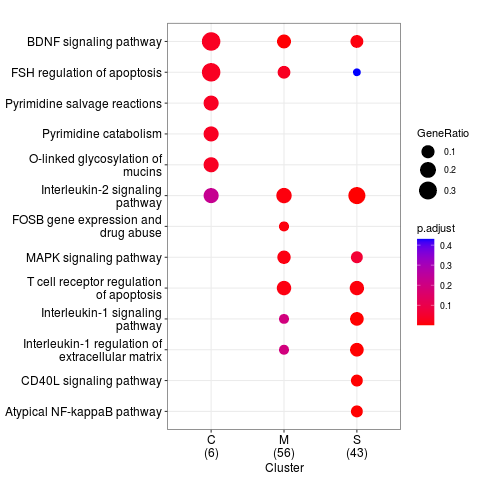

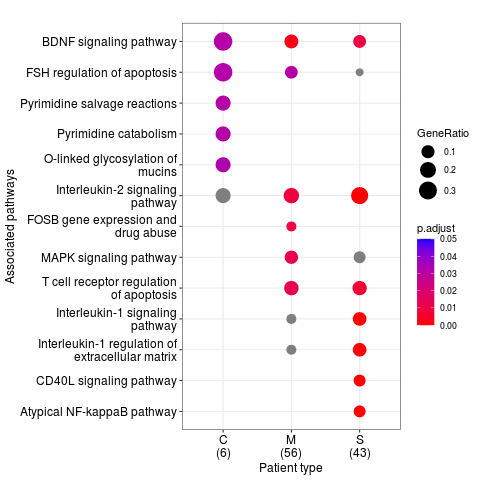

In [7]:
%%R
p <- dotplot(ck, showCategory=5) + 
    labs(y = 'Associated pathways', x = 'Patient type') + 
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red")
ggsave(p, filename='tmp/dotplot_enrichr.pdf', width=7, height=8)
p

## Cnetplot

R[write to console]: Saving 6.67 x 6.67 in image



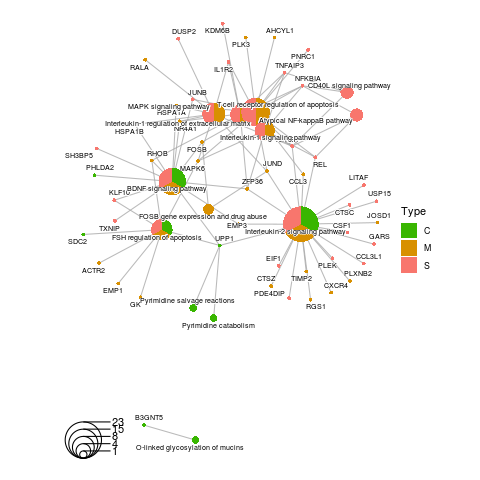

In [8]:
%%R
p <- cnetplot(ck, cex_category=1) + 
    scale_fill_manual(values=c(colors$green, colors$yellow, colors$red)) +
    guides(fill=guide_legend(title="Type"))
p <- remove_legend_title(p)
ggsave(p, filename='tmp/cnetplot_enrichr.pdf')
p

## NK cell

In [4]:
types = ['C', 'M', 'S']
genes = {
    'C': 'CAPZA1 TTC39C-AS1 GABARAPL2 NCOR1 BRD4 RPS6KA3 STAG2'.split(' '),
    'M': 'DNAJA1 SMIM15 LUCAT1 PSMA3 LCOR RABGAP1L LAGE3 COTL1 ZC3H18 LPIN2 NFE2L3 GCH1 KLF6 SKAP1 HSP90AA1 ADAR BTG1 COX17 SLC7A5 MYBL2 TAF8 RECQL4 CDCA5 MT1E CDC6 CDC20 CAB39 CERKL PKMYT1 JADE2 CLSPN ZBTB32 COX6A1 LBR LDB1 ANXA2 B9D2 SACS BBX RPLP0 CD151 MARK4 SQSTM1 HDAC2 ENOPH1 PRKAB2 DNAJC5 LAMP2 RABAC1 DYNLL1 ZNF750 MTRNR2L6 LSP1'.split(' '),
    'S': 'GUK1 RCC2 RPL18 MYL12A FAU PNISR SFXN1 RPS16 ERGIC3 SNRNP70 ALDOA RPL36 EIF4A2 RPL10 EIF6 RPLP2 SLC25A3 EZR RALY SRSF5 ACTN4 RPL28 TRAPPC1 PPP1CA RPL31 MZT2B IRF1 ATP1B3 PCBP1 EMD RPL38 FBXO7 PFDN5 CORO1A SNF8 UHMK1 RPS9 PRDX5 NACA CNBP GPX4 C9orf16 TRMT112 FYTTD1 BCAP31 SPTLC2 RPL5 PPP1R12A HOPX NDUFB6 SSR4 RPL10A RAC2 VDAC1 ANXA6 SON ZER1 RPS5 RPL9 LSP1 SNRPD2 RHOG RPL15 IRF4 C8orf59 XRCC5 SEC11A MMP25-AS1 MASTL UBA52 GABARAP RPL14 NFKB1 MYL6 HCST CD7 IL4I1 FFAR2 CCL2 GABARAP BZW1 TIMP2 TMEM140 NECAP1 ZNF800 SAMD4A CCL8 GSTO1 SKAP2 GLG1 SUPT3H DNPEP YWHAZ PPP3CC'.split(' ')
}
dfs = {}
for t in types:
    dfs[t] = pd.read_csv(f'tmp/pyscenic_NK_cells_{t}.txt', sep='\t')
dfs['C'].head()

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,RSK activation,1/6,0.002098,0.057103,0,0,666.266667,4108.590826,RPS6KA3
1,CREB phosphorylation,1/7,0.002448,0.057103,0,0,555.194444,3338.153583,RPS6KA3
2,Mitotic metaphase/anaphase transition,1/8,0.002797,0.057103,0,0,475.857143,2797.660500,STAG2
3,Advanced glycosylation endproduct receptor sig...,1/13,0.004542,0.057103,0,0,277.513889,1497.032601,CAPZA1
4,Innate immune system,2/319,0.005051,0.057103,0,0,24.827760,131.293049,RPS6KA3;CAPZA1


In [5]:
processed_dfs = {}
top_n = 5

for t in types:
    processed_dfs[t] = dfs[t].sort_values('Adjusted P-value', ascending=True) # .iloc[:top_n, :]
    processed_dfs[t]['type'] = t
    processed_dfs[t] = processed_dfs[t].rename(columns={'Adjusted P-value': 'p.adjust', 'Combined Score': 'Score'})
    processed_dfs[t]['Genes'] = processed_dfs[t]['Genes'].map(lambda x: x.replace(';', '/'))
    processed_dfs[t]['Ratio'] = processed_dfs[t].apply(lambda x: f"{x['Overlap'][:x['Overlap'].find('/')]}/{len(genes[t])}", axis=1)
    
final_df = pd.concat([df for df in processed_dfs.values()], axis=0).reset_index(drop=True)
final_df = final_df.assign(ID=[f'ID_{el}' for el in pd.factorize(final_df['Term'])[0] + 1])
final_df

,Term,Overlap,P-value,p.adjust,Old P-value,Old Adjusted P-value,Odds Ratio,Score,Genes,type,Ratio,ID
0,RSK activation,1/6,0.002098,0.057103,0,0,666.266667,4108.590826,RPS6KA3,C,1/7,ID_1
1,HES/HEY pathway,1/48,0.016682,0.057103,0,0,70.730496,289.530534,NCOR1,C,1/7,ID_2
2,Regulation of transcription by NOTCH1 intracel...,1/47,0.016337,0.057103,0,0,72.271739,297.350246,NCOR1,C,1/7,ID_3
3,Mitotic prometaphase,1/43,0.014955,0.057103,0,0,79.170635,332.729205,STAG2,C,1/7,ID_4
4,Transcriptional activity of SMAD2/SMAD3-SMAD4 ...,1/41,0.014264,0.057103,0,0,83.137500,353.335453,NCOR1,C,1/7,ID_5
...,...,...,...,...,...,...,...,...,...,...,...,...
765,FSH regulation of apoptosis,1/263,0.708850,0.715179,0,0,0.815010,0.280454,EZR,S,1/94,ID_75
766,Metabolism,6/1615,0.771740,0.776896,0,0,0.784295,0.203217,IL4I1/SPTLC2/NDUFB6/GUK1/GSTO1/ALDOA,S,6/94,ID_89
767,Generic transcription pathway,1/377,0.830330,0.834020,0,0,0.564610,0.104979,UBA52,S,1/94,ID_80
768,Signal transduction,3/1020,0.859532,0.861437,0,0,0.619141,0.093718,CCL2/FFAR2/NFKB1,S,3/94,ID_88


In [6]:
%%R -i final_df

egos <- list()
for (group in c('C', 'M', 'S')){
    df <- final_df[final_df['type'] == group,]
    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')
}

ck <- merge_result(list(C=egos[['C']], M=egos[['M']], S=egos[['S']]))
ck@fun <- 'enrichGO'

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



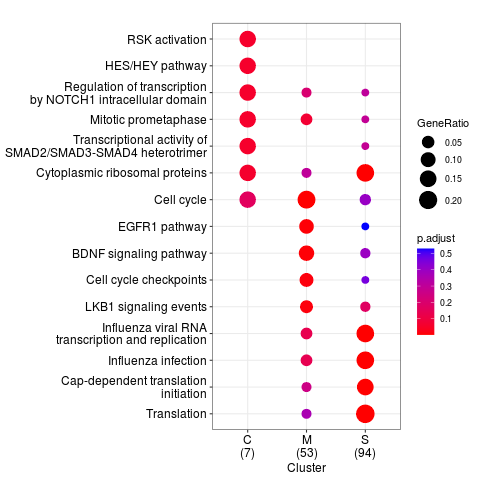

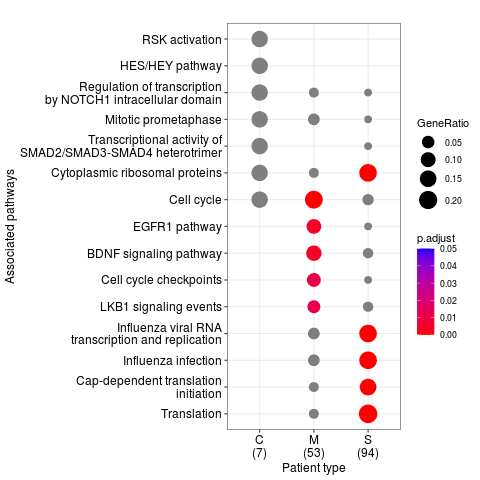

In [7]:
%%R
p <- dotplot(ck, showCategory=5) + 
    labs(y = 'Associated pathways', x = 'Patient type') + 
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red")
ggsave(p, filename='tmp/dotplot_enrichr.pdf', width=7, height=8)
p

## Cnetplot

R[write to console]: Saving 6.67 x 6.67 in image



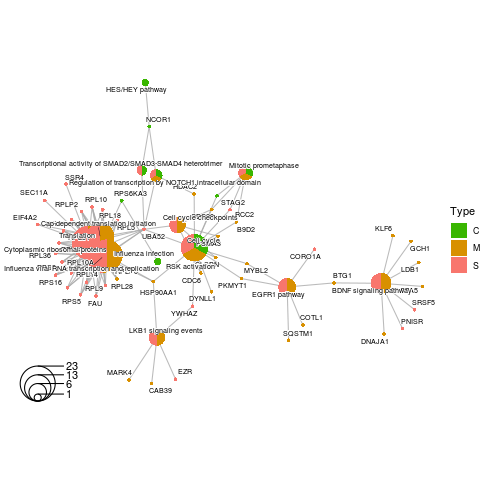

In [8]:
%%R
p <- cnetplot(ck, cex_category=1) + 
    scale_fill_manual(values=c(colors$green, colors$yellow, colors$red)) +
    guides(fill=guide_legend(title="Type"))
p <- remove_legend_title(p)
ggsave(p, filename='tmp/cnetplot_enrichr.pdf')
p

# OTHER COMMUNITY ANALYSIS

## T cells

In [134]:
_DATA_HOME = '/gpfs/projects/bsc08/bsc08890/res/covid_19'
algo = 'leiden'
data = 'T_cells'
data_type = 'all'
run_top_n = 50

community_data = pd.read_pickle(os.path.join(
    _DATA_HOME, 'cell_types', data, 'data', 'grnboost2', f'{algo}_communities', 
    f'raw_data_communities_info.pickle'
))

df = pd.concat([
        pd.DataFrame({
            'cluster': f'cluster_{i}',
            'gene': [el[: el.find(' ')] for el in vals.split('; ')][:run_top_n]
        }) for i, vals in community_data['all_sorted_genes'].iteritems()
], axis=0).reset_index(drop=True)

%R -i 

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,Immune System Homo sapiens R-HSA-168256,16/1547,5.971219e-07,0.000133,0,0,5.661505,81.135852,JUN;DUSP2;KLRB1;DUSP1;FOS;RASGRP2;TNF;NFKBIA;S...
1,Cytokine Signaling in Immune system Homo sapie...,8/620,1.386370e-04,0.012570,0,0,6.018674,53.467806,SOCS2;DUSP2;DUSP1;LTA;IL17F;IL7R;TNF;IL17A
2,Interleukin-17 signaling Homo sapiens R-HSA-44...,2/8,1.698630e-04,0.012570,0,0,138.500000,1202.251780,IL17F;IL17A
3,Activation of the AP-1 family of transcription...,2/10,2.721231e-04,0.015103,0,0,103.864583,852.650959,JUN;FOS
4,Fc epsilon receptor (FCERI) signaling Homo sap...,6/395,4.357214e-04,0.018447,0,0,6.857093,53.063664,NFKBIA;JUN;DUSP2;DUSP1;FOS;RASGRP2


In [131]:
processed_dfs = {}
processed_types = []
top_n = 5

for t in types:
    if len(dfs[t]) != 0:
        processed_types.append(t)
        processed_dfs[t] = dfs[t].sort_values('Adjusted P-value', ascending=True) # .iloc[:top_n, :]
        processed_dfs[t]['type'] = t
        processed_dfs[t] = processed_dfs[t].rename(columns={'Adjusted P-value': 'p.adjust', 'Combined Score': 'Score'})
        processed_dfs[t]['Genes'] = processed_dfs[t]['Genes'].map(lambda x: x.replace(';', '/'))
        processed_dfs[t]['Ratio'] = processed_dfs[t].apply(lambda x: f"{x['Overlap'][:x['Overlap'].find('/')]}/{len(genes[t])}", axis=1)
    
final_df = pd.concat([df for df in processed_dfs.values()], axis=0).reset_index(drop=True)
final_df = final_df.assign(ID=[f'ID_{el}' for el in pd.factorize(final_df['Term'])[0] + 1])
final_df

,Term,Overlap,P-value,p.adjust,Old P-value,Old Adjusted P-value,Odds Ratio,Score,Genes,type,Ratio,ID
0,Immune System Homo sapiens R-HSA-168256,16/1547,5.971219e-07,0.000133,0,0,5.661505,81.135852,JUN/DUSP2/KLRB1/DUSP1/FOS/RASGRP2/TNF/NFKBIA/S...,cluster_0,16/50,ID_1
1,Cytokine Signaling in Immune system Homo sapie...,8/620,1.386370e-04,0.012570,0,0,6.018674,53.467806,SOCS2/DUSP2/DUSP1/LTA/IL17F/IL7R/TNF/IL17A,cluster_0,8/50,ID_2
2,Interleukin-17 signaling Homo sapiens R-HSA-44...,2/8,1.698630e-04,0.012570,0,0,138.500000,1202.251780,IL17F/IL17A,cluster_0,2/50,ID_3
3,Activation of the AP-1 family of transcription...,2/10,2.721231e-04,0.015103,0,0,103.864583,852.650959,JUN/FOS,cluster_0,2/50,ID_4
4,Toll Like Receptor 2 (TLR2) Cascade Homo sapie...,3/92,1.578840e-03,0.018447,0,0,14.244083,91.889506,NFKBIA/JUN/FOS,cluster_0,3/50,ID_5
...,...,...,...,...,...,...,...,...,...,...,...,...
2172,Gene Expression Homo sapiens R-HSA-74160,3/1631,7.857353e-01,0.808621,0,0,0.718360,0.173222,GTF3C2/MYBBP1A/ELL2,cluster_11,3/50,ID_64
2173,Transmembrane transport of small molecules Hom...,1/594,7.789512e-01,0.808621,0,0,0.666173,0.166415,SLC2A5,cluster_11,1/50,ID_210
2174,Metabolism of lipids and lipoproteins Homo sap...,1/659,8.131293e-01,0.828766,0,0,0.598350,0.123778,AGPAT5,cluster_11,1/50,ID_86
2175,Developmental Biology Homo sapiens R-HSA-1266738,1/786,8.656296e-01,0.873874,0,0,0.498245,0.071896,COL4A4,cluster_11,1/50,ID_103


In [132]:
%%R -i final_df,processed_types,num_nodes_per_cluster

# Define some useful functions
get_cl_from_tick <- function (x) substr(x, 1, as.integer(gregexpr('\n', x)) - 1)
cl_name_to_int <- function (x) substr(x, as.integer(gregexpr('_', x)) + 1, nchar(x))

processed_types = unlist(processed_types)

egos <- list()
for (group in processed_types){
    df <- final_df[final_df['type'] == group,]
    egos[[group]] <- enrichDF2enrichResult(df, keyColname='ID', descriptionColname='Term', geneRatioColname='Ratio', geneColname='Genes', pvalueColname='p.adjust')
}

merge_cmd = ""
for (t in processed_types){
    merge_cmd = paste0(merge_cmd, sprintf("%s=egos[['%s']], ", t, t))
}

merge_cmd = sprintf("merge_result(list(%s))", substr(merge_cmd, 1, nchar(merge_cmd) - 2))

ck <- eval(parse(text=merge_cmd))
ck@fun <- 'enrichGO'

### Dotplot

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



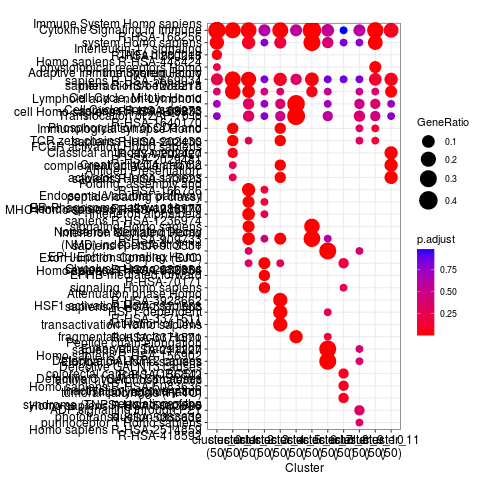

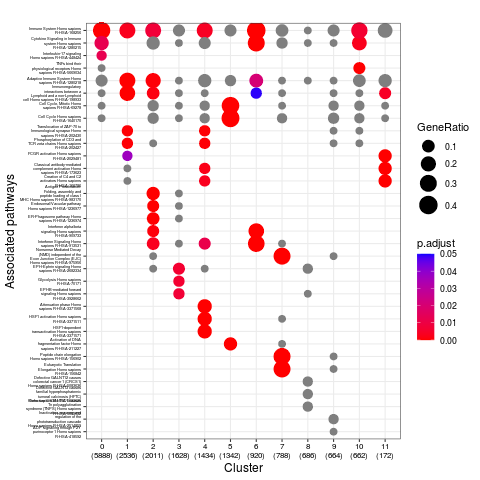

In [133]:
%%R
p <- dotplot(ck, showCategory=3) + 
    labs(y = 'Associated pathways', x = 'Cluster') + 
    scale_color_gradient(limit = c(0, 0.05), high = "blue", low = "red") +
    theme(axis.text.y = element_text(size = 4), axis.text.x = element_text(size=8))
    
new_ticks <- lapply(ggplot_build(p)$layout$panel_params[[1]]$x.sec$scale$range$range, 
                    function (x) paste0(cl_name_to_int(get_cl_from_tick(x)), '\n', sprintf('(%s)', num_nodes_per_cluster[[get_cl_from_tick(x)]])))
p <- p + scale_x_discrete(labels=new_ticks)
    
ggsave(p, filename='tmp/dotplot_enrichr.pdf', width=7, height=8)
p

## Cnetplot

In [ ]:
%%R
names(ggplot_build(p))

In [ ]:
%%R
p <- cnetplot(ck, cex_category=1) +
    guides(fill=guide_legend(title="Cluster"))
p <- remove_legend_title(p)
ggsave(p, filename='tmp/cnetplot_enrichr.pdf')
p

## Macrophage

##### Enrichment analysis

In [28]:
def prepare_gsea_ora(data, data_type, ora_top_n, top_n_dotplot):
    
    algo = 'leiden'
    
    if data_type == 'all':
        df = pd.read_pickle(os.path.join(
            _DATA_HOME, 'cell_types', data, 'data', 'grnboost2', f'{algo}_communities', 
            f'raw_data_communities_info.pickle'
        ))
    else:
        df = pd.read_pickle(os.path.join(
            _DATA_HOME, 'cell_types', data, 'data', 'grnboost2', f'{algo}_communities', 
            f'raw_data_{data_type}_type_communities_info.pickle'
        ))

    gsea_input = pd.concat([
        pd.DataFrame({
            'cluster': f'cluster_{i}',
            'gene': [el[: el.find(' ')] for el in vals.split('; ')],
            'centrality': [float(el[el.find('=') + 1:el.find(')')]) for el in vals.split('; ')]
        }) for i, vals in df['all_sorted_genes'].iteritems()
    ], axis=0).reset_index(drop=True)

    ora_input = pd.concat([
        pd.DataFrame({
            'cluster': f'cluster_{i}',
            'gene': [el[: el.find(' ')] for el in vals.split('; ')][:ora_top_n]
        }) for i, vals in df['all_sorted_genes'].iteritems()
    ], axis=0).reset_index(drop=True)
    
    gsea_input.to_csv('tmp/tmp_gsea_input.tsv', sep='\t', index_label=False)
    ora_input.to_csv('tmp/tmp_ora_input.tsv', sep='\t', index_label=False)

    print('Saved data, please run in terminal:')
    print()
    print('source("src/func.R")')
    print(r"markers_df_ora <- read.table('tmp/tmp_ora_input.tsv', sep='\t')")
    print(f'out_ora <- run_ora(markers_df_ora, is_clusters=T, '
          f'cell_type_for_community_ana="{data} {data_type}", top_n_dotplot={top_n_dotplot})')
    print(r"markers_df_gsea <- read.table('tmp/tmp_gsea_input.tsv', sep='\t')")
    print("out_gsea <- run_gsea(markers_df_gsea, is_clusters=T)")
    print()
    
    
widget = interactive(
    prepare_gsea_ora, 
    {'manual': True},
    data=['Macrophage', 'T_cells', 'DC', 'Monocyte', 
          'NK_cell', 'B_cell', 'Epithelial_cells', 'Neutrophils', 
          'Pre-B_cell_CD34-'], 
    ora_top_n=[50, 60, 40, 70, 30, 80, 20, 10],
    data_type=['all', 'C', 'M', 'S'],
    top_n_dotplot=[3, 5, 10]
)
display(widget)

interactive(children=(Dropdown(description='data', options=('Macrophage', 'T_cells', 'DC', 'Monocyte', 'NK_cel…

##### Enrichr analysis

In [29]:
def prepare_enrichr(data, data_type, top_n):
    
    algo = 'leiden'
    
    df = pd.read_pickle(
        os.path.join(_DATA_HOME, 'cell_types', data, 'data', 
                     'grnboost2', f'{algo}_communities', f'raw_data_communities_info.pickle')
    )

    if data_type == 'all':
        df = pd.read_pickle(os.path.join(
            _DATA_HOME, 'cell_types', data, 'data', 'grnboost2', f'{algo}_communities', 
            f'raw_data_communities_info.pickle'
        ))
    else:
        df = pd.read_pickle(os.path.join(
            _DATA_HOME, 'cell_types', data, 'data', 'grnboost2', f'{algo}_communities', 
            f'raw_data_{data_type}_type_communities_info.pickle'
        ))
    
    df_input = pd.concat([
        pd.DataFrame({
            'cluster': f'cluster_{i}',
            'gene': [el[: el.find(' ')] for el in vals.split('; ')][:top_n]
        }) for i, vals in df['all_sorted_genes'].iteritems()
    ], axis=0).reset_index(drop=True)
    
    for cl in df_input['cluster'].unique():
        x = df_input[df_input['cluster'] == cl]['gene']
        print(colored(cl, 'cyan'))
        print(' '.join(x))
        print('\n'.join(x))
    
widget = interactive(
    prepare_enrichr, 
    {'manual': True},
    data=['Macrophage', 'T_cells', 'DC', 'Monocyte', 
          'NK_cell', 'B_cell', 'Epithelial_cells', 'Neutrophils', 
          'Pre-B_cell_CD34-'], 
    data_type = ['all', 'C', 'M', 'S'],
    top_n=[50, 60, 40, 70, 30, 80, 20, 10]
)
display(widget)

interactive(children=(Dropdown(description='data', options=('Macrophage', 'T_cells', 'DC', 'Monocyte', 'NK_cel…